# <span style="color:orange">**Dataset Preparation**</span>
___
___

### <u>Project Objective:</u> predict the likelihood and severity of power outages at the county level, 6 hours in advance, utilizing meteorological and demographic data.
- <u>Goal:</u> Provide reliable forecasts that allow immediate operational responses (dispatching repair crews, issuing customer warnings...)
- <u>Note:</u> the inherent variability in weather patterns makes it hard to provide accurate forecasts on a longer term (some days ahead).

### <u>Notebook purposes:</u>
- Prepare a dataset for model training and inference.
- Perform thorough data analysis with clear explanations.
- This notebook is where we truly make the data speak!

### <u>Brief description of the dataset structure and features:</u>

* One row **per hour** and **per fips.**

* **Demographic features:** Population, Age, Land & Water Areas.

* **Meteorological indicators:**
    * Temperature, Rain precipitation, Wind, Storms and Severe weather events.
    * Textual analysis of storms' reports from last hours.
      
<br>

* **Power outages:** 
    * Create a column "outages outbreak" to focus specifically on the apparition of outages outbreaks.
    * Analyze outages wave-fronts to forecast where they will hit in a few hours. They usually coincide with storms fronts.
      
<br>

* **Spatial features:**
    * Data aggregated at county level and neighboring counties (1st to 4th-degree adjacency), as well as state-level features.

        
<br>

* **Temporal trends:**
  * Rolling statistics (min, max, mean, sum ...) over the past hours/days.

### <u>External datasets used:</u>

| Dataset Description                | Source |
|-----------------------------------|--------|
| Daily weather information         | [NOAA Global Summary of the Day](https://www.ncei.noaa.gov/data/global-summary-of-the-day/) |
| FIPS latitudes and longitudes     | [US Latitudes & Longitudes](https://gist.github.com/russellsamora/12be4f9f574e92413ea3f92ce1bc58e6) |
| FIPS population by year           | [Population Data](https://seer.cancer.gov/popdata/download.html) |
| FIPS geographical information     | [US Census Shapefiles](https://www2.census.gov/geo/tiger/GENZ2021/shp/) |


___
___
# **Librairies & Functions**

In [1]:
from utility_script_dynamic_rythms import *

___
___
# **Open Data**
> - Aggregated EAGLE-I data.
> - This df is the output of the notebook `1a. Create CSV`.

In [2]:
%%time

# Open df
df = pd.read_csv(outages_data_filepath,
                 dtype={'fips':'int32',
                        'date':'object',
                        'hour':'int8',
                        'outages':'int32'},
                )

# Filter dates
df = df[df['date'].between('2023-11-01', '2024-01-01')].reset_index(drop=True)

# Show
print(df.shape)
df.head()

(1029759, 4)
CPU times: user 3.62 s, sys: 758 ms, total: 4.37 s
Wall time: 5.42 s


fips        date  hour  outages
0  1001  2023-11-01     0        4
1  1001  2023-11-01     2        6
2  1001  2023-11-01     3        4
3  1001  2023-11-01    21        7
4  1001  2023-11-02    11       17

___
___
# <span style="color:#0096FF;">**Part 1: Optimizing Temporal Resolution for Forecasting**</span>

To strike a balance between **memory efficiency** and **predictive accuracy**, I decided to aggregate the dataset from **15-minute intervals to hourly records** (one row per hour).

### <span style="color:#A7C7E7;">**Why Hourly Aggregation?**</span>
- **Memory Reduction**: Significantly reduces memory usage while maintaining key outage patterns.
- **Improved Precision**: Hourly aggregation enables models to detect patterns leading up to outages, without excessive noise from high-frequency fluctuations.

### <span style="color:#A7C7E7;">**Why Not Daily Aggregation?**</span>
- While I initially experimented with **daily aggregation** (one row per 24 hours), it lacked the **temporal granularity** necessary to capture the onset and evolution of outages.
- Weather conditions can change rapidly within 24 hours.


___
## <span style="color:#A7C7E7;">**<u>Step 1:</u></span> Ensure one row per fips and per hours.**

<span style="color:red;">**Problem:**</span> The provided CSV contains missing records, meaning that some FIPS don't have one row every 15 min. As a result, the hourly df can also have missing values, which will be problematic for lag features and reliable data analysis.
<br>
<span style="color:green;">**Solution:**</span> Generate rows for every possible hour within the dataset, and adjust the outage values using linear regression. This approach is more logical than imputing zeros for missing values, as it avoids scenarios like 3000 outages at 15:00, 0 at 15:15 and 2900 at 15:30, which may not make sense.


In [3]:
%%time

# Create a df with one row per fips and per hour (but without handling missing values)
df = ensure_df_has_one_row_per_hour(df)

# Show
print(df.shape)
df.head()

Date min : 2023-11-01.
Date max : 2023-12-31.
(4268242, 7)
CPU times: user 1.85 s, sys: 460 ms, total: 2.31 s
Wall time: 2.33 s


fips        date  month  week  dayofweek  hour  outages
0  1001  2023-11-01     11    44          2     0      4.0
1  1001  2023-11-01     11    44          2     1      NaN
2  1001  2023-11-01     11    44          2     2      6.0
3  1001  2023-11-01     11    44          2     3      4.0
4  1001  2023-11-01     11    44          2     4      NaN

### On the graph below, we can observe how many missing rows there were...



<Axes: xlabel='date'>

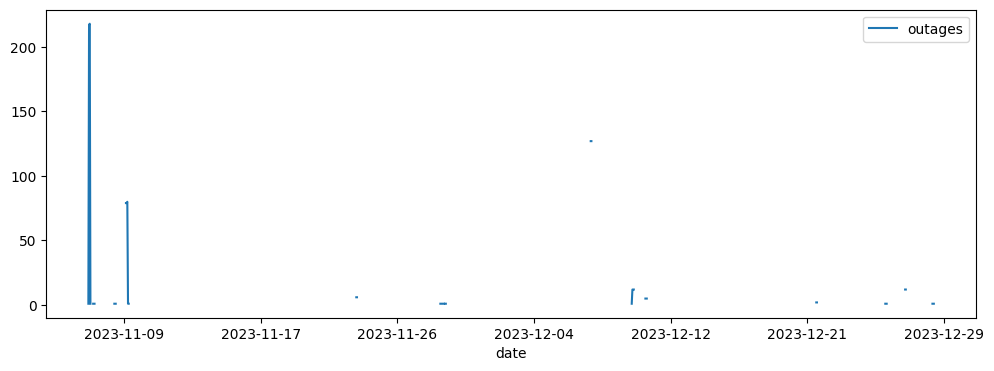

In [4]:
# Plot outages for fips 50013 from 2023-09 to 2023-12
mask = (df['fips'] == 50013) & (df['date'].between('2023-09-01', '2023-12-31'))
df[mask].plot(x = 'date',
            y = 'outages',
            figsize= (12, 4),
           )

### ... So let's fill them !
- If possible, the value for a row =H becomes the mean of H-1 et H+1. More extended linear regression are not used since it might create dangerous fake data.
- Otherwise, we fill it with 0.


In [5]:
%%time

# Complete missing values
df = complete_missing_values(df)

# Show
print(df.shape)
df.head()

(4268242, 7)
CPU times: user 1.04 s, sys: 119 ms, total: 1.15 s
Wall time: 1.14 s


fips        date  month  week  dayofweek  hour  outages
0  1001  2023-11-01     11    44          2     0      4.0
1  1001  2023-11-01     11    44          2     1      5.0
2  1001  2023-11-01     11    44          2     2      6.0
3  1001  2023-11-01     11    44          2     3      4.0
4  1001  2023-11-01     11    44          2     4      0.0

### On the graph below, we can see that missing values have been replaced (most of them by 0).



<Axes: xlabel='date'>

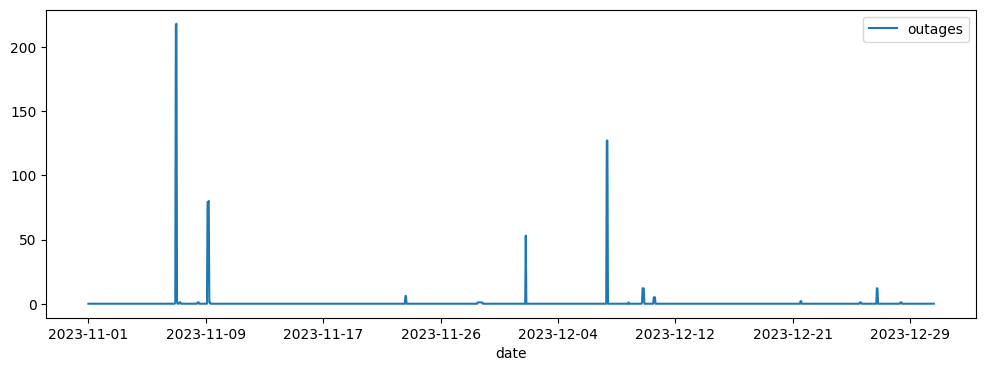

In [6]:
# Plot outages for fips 50013 from 2023-09 to 2023-12
mask = (df['fips'] == 50013) & (df['date'].between('2023-11-01', '2023-12-31'))
df[mask].plot(x = 'date',
            y = 'outages',
            figsize= (12, 4),
           )

___  
___  

# <span style="color:#0096FF;">**Part 2: Identify Outages Outbreaks.**</span>

### **Goals**
- Pinpoint **when the peak occurs** as precisely as possible, rather than analyzing the entire curve of outages.
- Help our future model to predict more precisely when the outages **initial rise**.
 
### *Methodology*
*- Identify and analyze **outages peaks**, allowing us to better understand the primary triggers of outages and forecast their occurrence probabilities effectively.*

### Let's identify sudden raises in outages.

___
## <span style="color:#A7C7E7;">**<u>Step 1:</u></span> Peak Detection.**

In [7]:
%%time

# Create envelop around outages
df = create_envelop(df)

# Apply peak detection to the column we created
df = peak_detection(df, col = 'envelop')

# Apply some corrections (to not mix up small peaks and fluctuations on big peaks)
df = peak_correction(df)

# Show df
print(df.shape)
df.head(1)

(4268242, 12)
CPU times: user 12.5 s, sys: 1.33 s, total: 13.9 s
Wall time: 11.8 s


fips        date  month  week  dayofweek  hour  outages  envelop  peak  \
0  1001  2023-11-01     11    44          2     0      4.0      NaN     0   

   peak_prominence  start_peak_x_hours_ago  end_peak_in_x_hours  
0              0.0                       0                    0

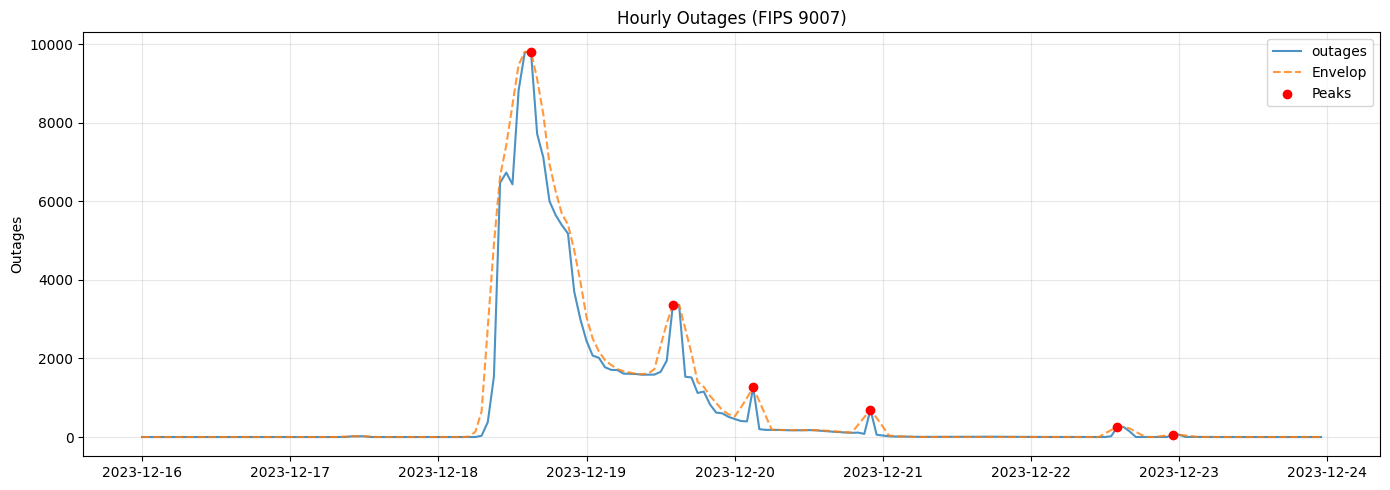

In [8]:
# Show result for fips n°9007 (Middlesex County - New Jersey)
plot_peaks(df,
           fips=9007,
           cols_to_plot = ['outages', 'envelop', 'peak'],
           start_date = '2023-12-16',
           end_date   = '2023-12-23') 

___
## <span style="color:#A7C7E7;">**<u>Step 2:</u></span> Identify outages outbreaks.**
- Use the number of hours since a peak has started.

In [9]:
# Generate an asymmetric gaussian with a slower ascension and a quicker descent to model the peaks
df = create_gaussian_around_peaks(df, peak_col='peak', col_to_create='outages_outbreak')

# Delete columns we no longer need
df = df.drop(columns = ['peak', 'start_peak_x_hours_ago', 'end_peak_in_x_hours', 'peak_prominence'])

# Show df
print(df.shape)
df.head(1)

(4268242, 9)


fips        date  month  week  dayofweek  hour  outages  envelop  \
0  1001  2023-11-01     11    44          2     0      4.0      NaN   

   outages_outbreak  
0               0.0

### Show some outages outbreaks

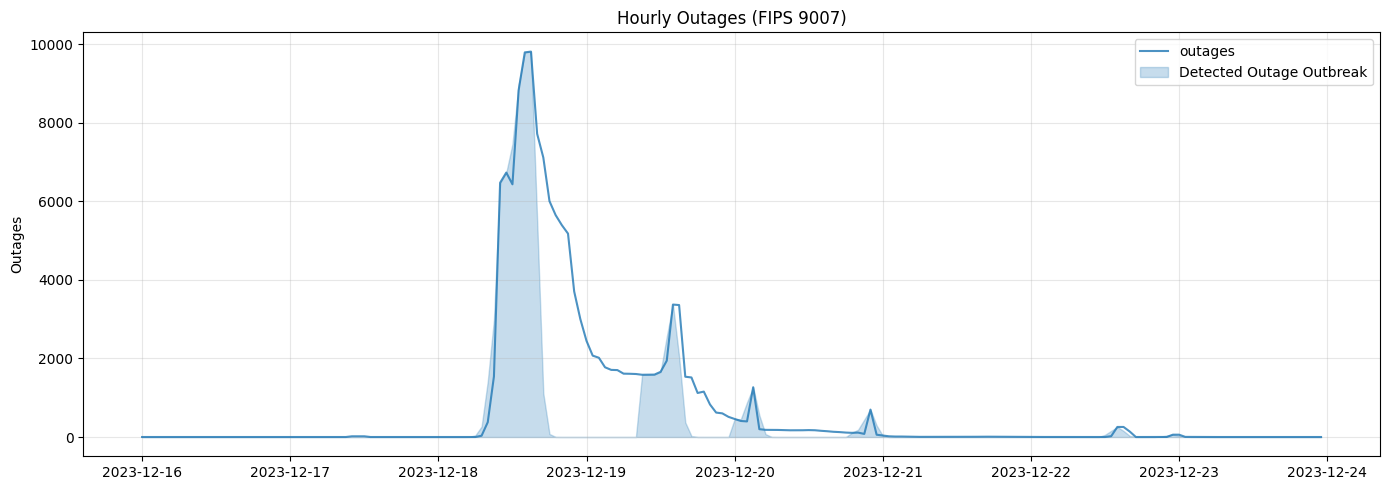

In [10]:
# Show result for fips n°9007 (Middlesex County - New Jersey)
plot_peaks(df,
           fips=9007,
           start_date = '2023-12-16',
           end_date   = '2023-12-23') 

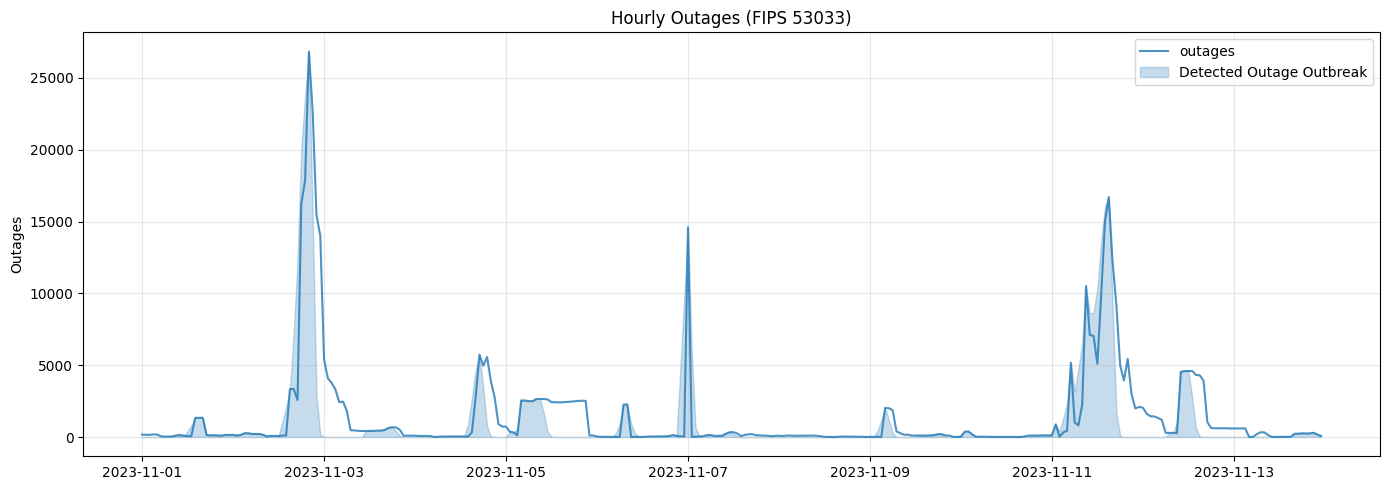

In [11]:
# Show result for fips n°53033 (King County - Washington)
plot_peaks(df,
           fips=53033,
           start_date = '2023-11-01',
           end_date   = '2023-11-13') 

___  
___  

# <span style="color:#0096FF;">**Part 3: Find adjacent neighbours (at fips level).**</span>

### **Goal**
- Connect fips data to their neighbours' (1st to 4th-degree adjacency).

### *Idea*
*- Before hitting a county, an outage outbreak might often hit its neighbours some hours earlier. This can thus help us identify outages waves and forecast where they will hit.*

### Create a dataframe with latitude & longitude of each county, as well as geographical boundaries

In [12]:
# Source for shapefile : https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_20m.zip
df_counties_gpd = gpd.read_file(gpd_url)

# Set types
df_counties_gpd['GEOID'] = df_counties_gpd['GEOID'].astype(int)

# Set index
df_counties_gpd.index = df_counties_gpd['GEOID']

# Show
print(df_counties_gpd.shape)
df_counties_gpd.head(1)

(3221, 13)


STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME  \
GEOID                                                              
13239      13      239  00350547  0500000US13239  13239  Quitman   

             NAMELSAD STUSPS STATE_NAME LSAD      ALAND    AWATER  \
GEOID                                                               
13239  Quitman County     GA    Georgia   06  391703076  24158295   

                                                geometry  
GEOID                                                     
13239  POLYGON ((-85.14183 31.83926, -85.11403 31.893...

In [13]:
# Open latitude and longitude of all counties (key = fips code)
df_latlong = pd.read_csv(path_to_latitude_longitude_file)

# Add Land and Water Areas
df_latlong = pd.merge(df_latlong,
                      df_counties_gpd[["GEOID",
                                       "ALAND",
                                       "AWATER"]].rename(columns = {"GEOID":"fips_code",
                                                                    "ALAND" : "LandArea",
                                                                    "AWATER" : "WaterArea",
                                                                   }),
                      how = 'left',
                      on = 'fips_code',
                     )

# Convert areas in km²
for k in ['LandArea', 'WaterArea'] :
    df_latlong[k] = round(df_latlong[k].fillna(0) /1e6).astype(int) # convert in km²

# Rename
df_latlong = df_latlong.rename(columns = {'fips_code':'fips', 'lng':'lon'})

# Show
print(df_latlong.shape)
df_latlong.head(1)

(3233, 6)


fips      name        lon        lat  LandArea  WaterArea
0  1059  Franklin -87.843283  34.442381      1642         33

### Create a dictionnary (key = fips code) with information about each fips
The use of a dictionnary structure makes the process faster.

In [14]:
# Store information in a dict for easier later use
dict_fips = {}
for i, row in df_latlong.iterrows():
    dict_fips[int(row['fips'])] = {'name' : row['name'],
                                   'latitude' : row['lat'],
                                   'longitude' : row['lon'],
                                   'LandArea' : row['LandArea'], # convert in km²
                                   'WaterArea' : row['WaterArea'], # convert in km²
                                  }

# Exemple for fips n°1021 (Chilton, Alabama)
dict_fips[1021]

{'name': 'Chilton',
 'latitude': 32.84771004,
 'longitude': -86.71887934,
 'LandArea': 1794,
 'WaterArea': 21}

### Find direct neighbours of all fips (1st-degree adjacency)

In [15]:
# First pass to have all direct neighbours for all fips in df
for main_fips in tqdm(dict_fips.keys(), position=0, leave=True) :

    # 1st-degree neighbours
    adjacent_fips_1st, far_neighbours = find_adjacent_fips(df_counties_gpd, main_fips)
    dict_fips[main_fips]['neighbours_1st'] = adjacent_fips_1st
    dict_fips[main_fips]['far_neighbours'] = far_neighbours

100%|██████████| 3233/3233 [02:31<00:00, 21.40it/s]


### Find 2nd to 4th-degree adjacent neighbours of all fips

In [16]:
# 2nd pass to get 2nd to 4th-degree neighbours
dict_fips = complete_dict_fips_with_indirect_neighbours(dict_fips)

# Show kleys of dictionnary
list(dict_fips[1001].keys())

100%|██████████| 3233/3233 [00:00<00:00, 8751.93it/s]


['name',
 'latitude',
 'longitude',
 'LandArea',
 'WaterArea',
 'neighbours_1st',
 'far_neighbours',
 'neighbours_2nd',
 'neighbours_3rd',
 'neighbours_4th',
 'LandArea_neighbours_1st',
 'WaterArea_neighbours_1st',
 'LandArea_neighbours_2nd',
 'WaterArea_neighbours_2nd',
 'LandArea_neighbours_3rd',
 'WaterArea_neighbours_3rd',
 'LandArea_neighbours_4th',
 'WaterArea_neighbours_4th']

### Let's plot some fips and their neighbours on a map !

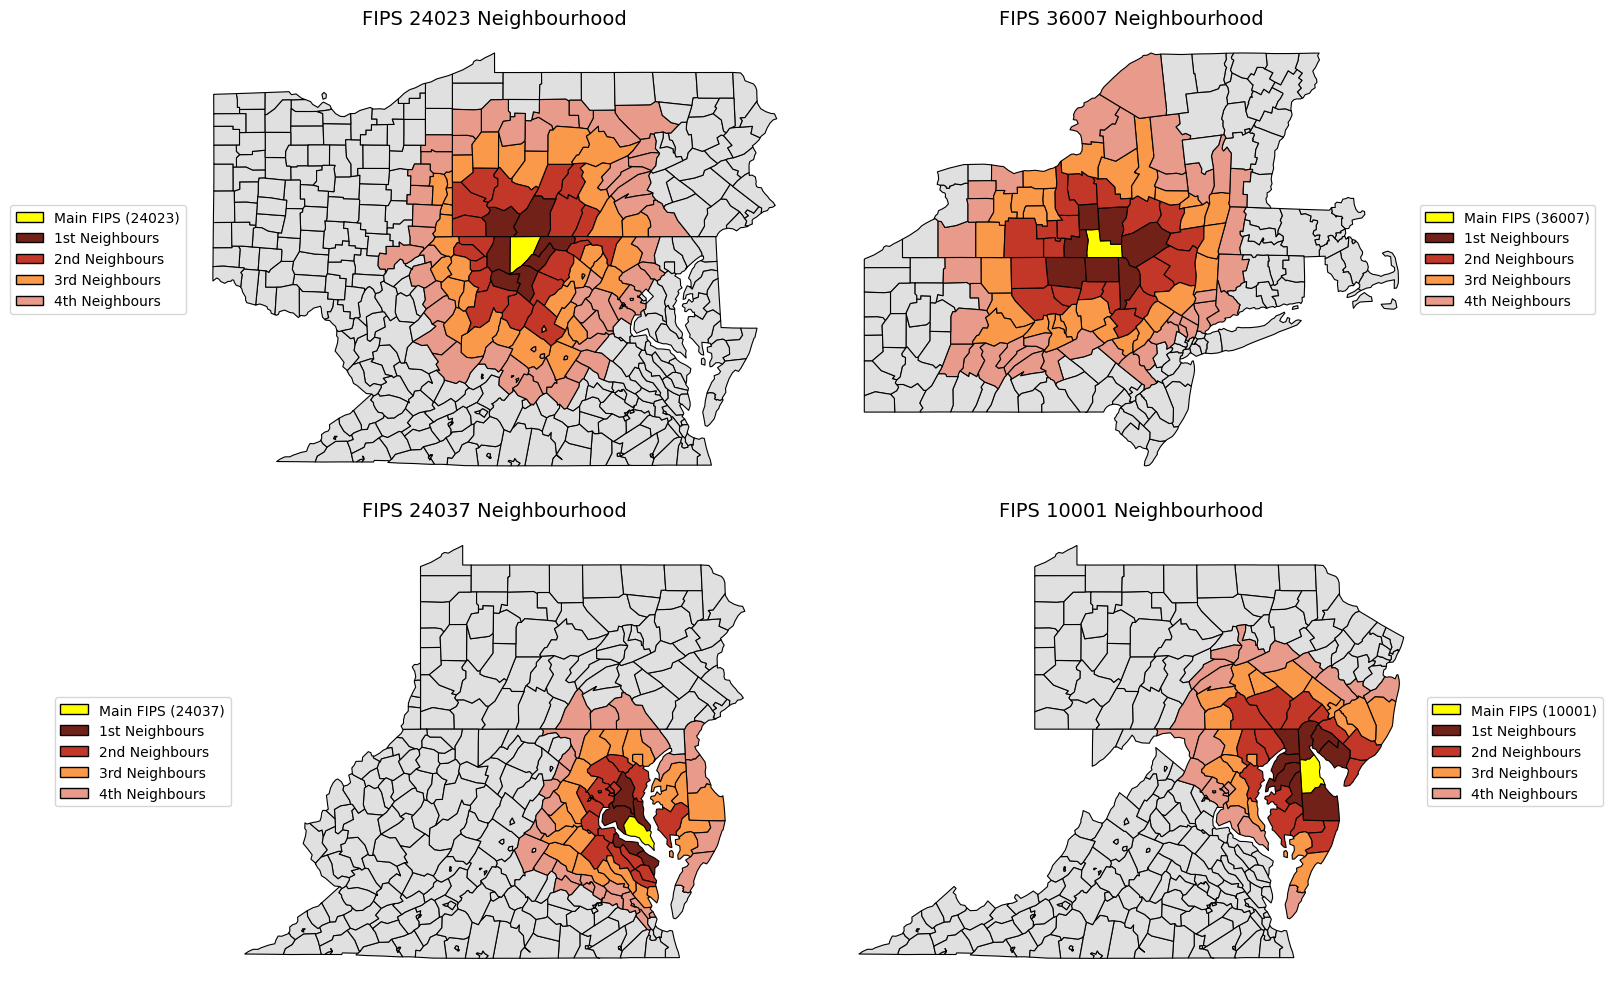

In [17]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10)) # 2 rows, 2 columns

# Plot 4 graphs with their respective axes
plot_fips_and_neighbors_on_map(df, fips=24023, dict_fips=dict_fips, legend='left', axe=axes[0, 0])
plot_fips_and_neighbors_on_map(df, fips=36007, dict_fips=dict_fips, legend='right', axe=axes[0, 1])
plot_fips_and_neighbors_on_map(df, fips=24037, dict_fips=dict_fips, legend='left', axe=axes[1, 0])
plot_fips_and_neighbors_on_map(df, fips=10001, dict_fips=dict_fips, legend='right', axe=axes[1, 1])

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()

### <u>Note:</u> the last two graphs (for FIPS codes 24037 and 10001) illustrate that neighboring regions might not be directly adjacent (for example, they may be separated by lakes or bodies of water). To account for this, I considered not only shared borders, but also geographic distance when determining neighborhood relationships.

___
___
# Now, let's observe the propagation of an outages outbreak.

##### To do so, let's focus on some outages outbreaks that occured in December 2023.

___
## By looking at fips n°23003, we can see that the outages expand this way :

### <span style="color:#E99B8B;">4th neighbours</span>  ➡️  <span style="color:#F99949;">3rd neighbours</span>  ➡️  <span style="color:#c23728;">2nd neighbours</span>  ➡️  <span style="color:#722118;">1st neighbours</span>  ➡️  <span style="color:yellow;">FIPS 23003</span>

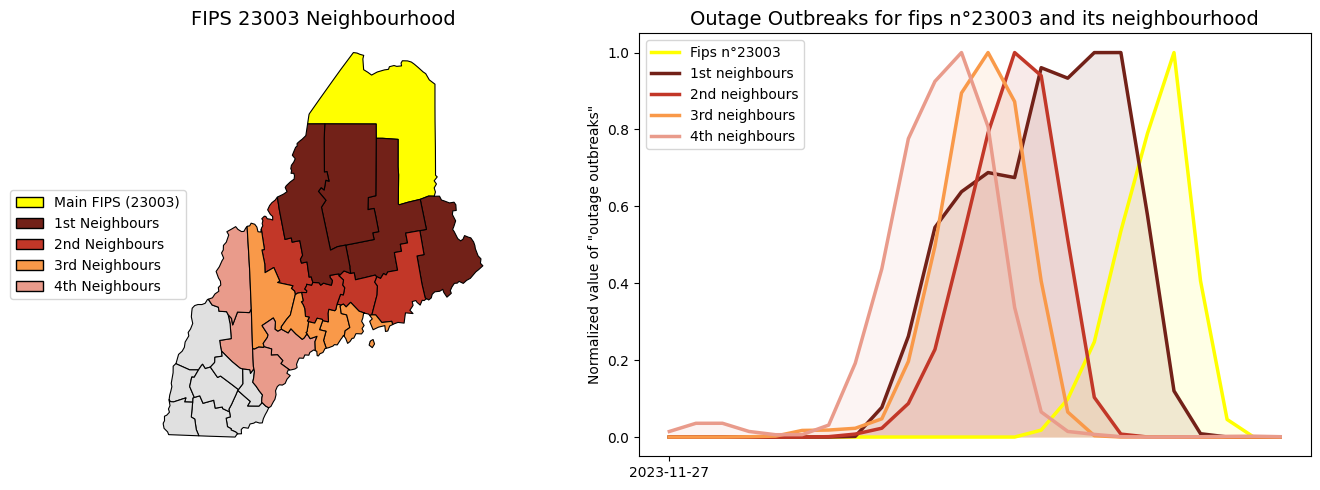

In [18]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 rows, 2 columns

# Plot 4 graphs with their respective axes
plot_fips_and_neighbors_on_map(df, fips=23003, dict_fips=dict_fips, legend='left', axe=axes[0])
plot_fips_and_neighbors_outages(df, fips=23003, dict_fips=dict_fips, start_date='2023-11-27', end_date='2023-11-27', axe=axes[1])

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()

## Same observation for fips 1007 (2023-12-10)

### <span style="color:#E99B8B;">4th neighbours</span>  ➡️  <span style="color:#F99949;">3rd neighbours</span>  ➡️  <span style="color:#c23728;">2nd neighbours</span>  ➡️  <span style="color:#722118;">1st neighbours</span>  ➡️  <span style="color:yellow;">FIPS 1007</span>

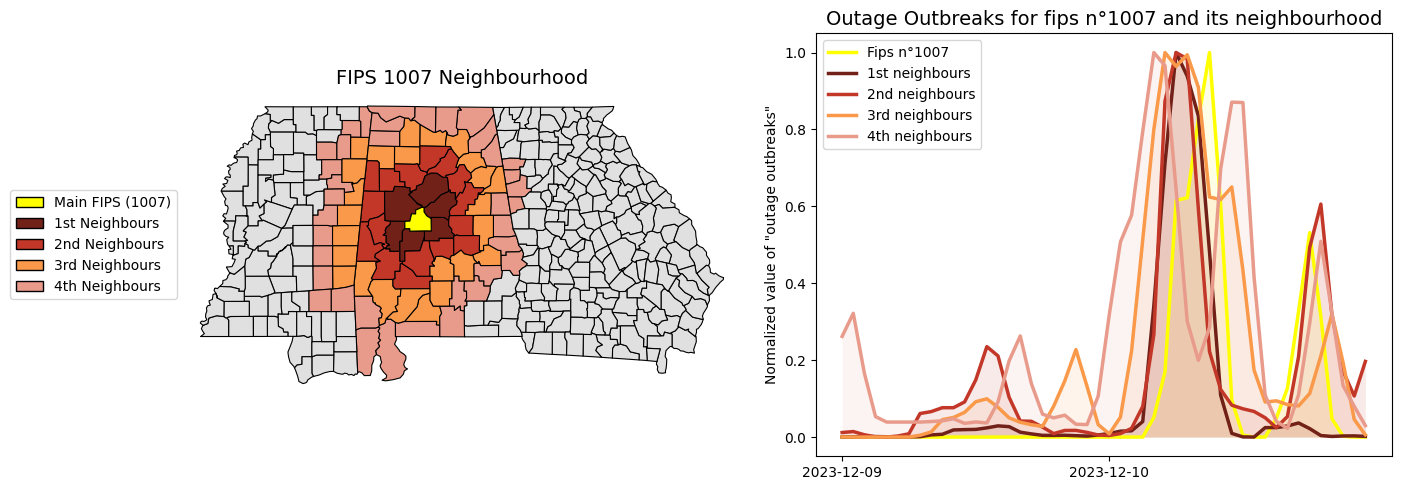

In [19]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 rows, 2 columns

# Plot 4 graphs with their respective axes
plot_fips_and_neighbors_on_map(df, fips=1007, dict_fips=dict_fips, legend='left', axe=axes[0])
plot_fips_and_neighbors_outages(df, fips=1007, dict_fips=dict_fips, start_date='2023-12-09', end_date='2023-12-10', axe=axes[1])

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()

## By looking at fips n°25013, we can see that the outages expand **the other way**:

###  <span style="color:yellow;">FIPS 25013</span>  ➡️  <span style="color:#722118;">1st neighbours</span>  ➡️  <span style="color:#c23728;">2nd neighbours</span>  ➡️  <span style="color:#F99949;">3rd neighbours</span>  ➡️  <span style="color:#E99B8B;">4th neighbours</span>

#### This indicates that the storm originated near our the 1st neighbors, before eventually reaching further counties.


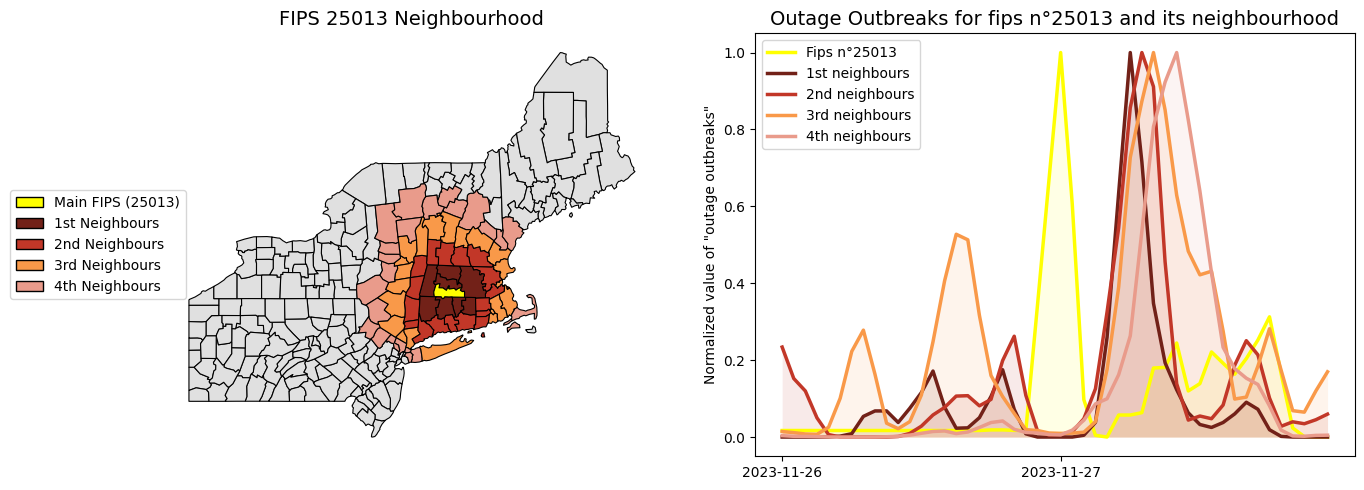

In [20]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 rows, 2 columns

# Plot 4 graphs with their respective axes
plot_fips_and_neighbors_on_map(df, fips=25013, dict_fips=dict_fips, legend='left', axe=axes[0])
plot_fips_and_neighbors_outages(df, fips=25013, dict_fips=dict_fips, start_date='2023-11-26', end_date='2023-11-27', axe=axes[1])

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()

___
___
# <span style="color:#0096FF;">**Part 4: Add proportions of fips with >50 outages in a radius of 300 and 600 kilometers.**</span>

### **Goal**
- Quantify regional outage intensity by computing the proportion of nearby FIPS (within 300 km and 600 km) exceeding 50 outages, capturing spatial dependencies to enhance predictive accuracy.

In [21]:
# Keep only fips codes of df in df_latlong
df_latlong = df_latlong[df_latlong['fips'].isin(df['fips'].unique())].reset_index(drop=True)

# Add proportions of fips with >50 outages in a radius of 300 and 600 kilometers.
df = add_number_of_fips_with_high_outages_in_radius(df,
                                                    df_latlong,
                                                    thr_outages=50,
                                                    radius=[300, 600],
                                                   )

# Show
print(df.shape)
df.head(1)

100%|██████████| 2961/2961 [11:24<00:00,  4.33it/s]


(4268242, 14)


fips        date  month  week  dayofweek  hour  outages  envelop  \
0  1001  2023-11-01     11    44          2     0      4.0      NaN   

   outages_outbreak  flag_more_than_50_outages  \
0               0.0                          0   

   Proportion_of_fips_within_300km_with_more_than_50_outages  \
0                                           0.011299           

   Proportion_of_fips_within_600km_with_more_than_50_outages  \
0                                           0.015723           

   max_Proportion_of_fips_within_300km_with_more_than_50_outages_over_last_24hours  \
0                                                0.0                                 

   max_Proportion_of_fips_within_600km_with_more_than_50_outages_over_last_24hours  
0                                                0.0

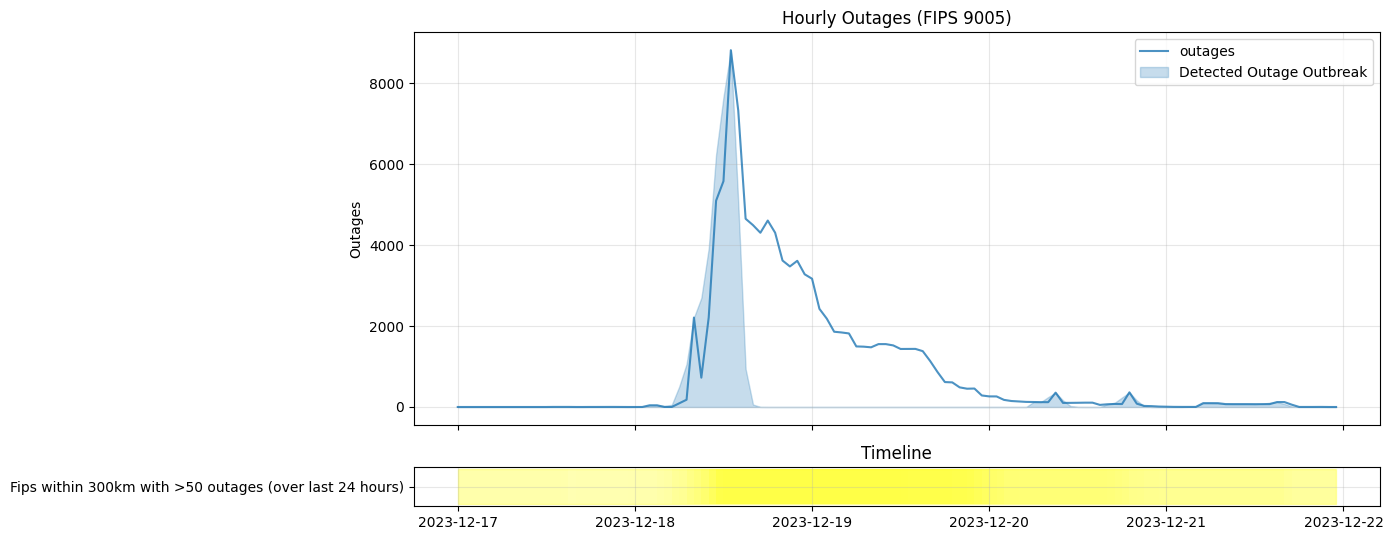

In [22]:
plot_peaks(df,
           fips=9005,
           start_date='2023-12-17',
           end_date='2023-12-21',
           cols_to_plot=['outages', 'outages_outbreak'],
           cols_timeline=['Severe_events_count',
                          'max_Proportion_of_fips_within_300km_with_more_than_50_outages_over_last_24hours',
                         ],
          )

___
___
# <span style="color:#0096FF;">**Part 5: Add daily temperature and max wind speed.**</span>

### **Goal**
- Integrate daily temperature and maximum wind speed per FIPS (and its neighbourhood) to capture weather-related drivers of outages.

### *Data source:*
https://www.ncei.noaa.gov/data/global-summary-of-the-day/

### Open CSV containing daily information about weather.
> These data have been collected by stations.

In [23]:
# Optimized data dtypes
dtypes = {'STATION': 'O',
          'DATE': 'O',
          'LATITUDE':'float32',
          'LONGITUDE': 'float32',
          'TEMP': 'float',
          'MXSPD': 'float32',
          'PRCP': 'float32',
          'Flag_Thunder': 'int8'}

# Read CSV
df_daily_weather = pd.read_csv(daily_weather_filepath,
                               dtype=dtypes,
                              )

# Rename columns
dict_rename = {'DATE': 'date',
               'TEMP': 'Temperature',
               'MXSPD': 'MaxWindSpeed',
               'PRCP': 'RainPrecipitation',
               'Flag_Thunder': 'Flag_Thunder',
              }
df_daily_weather = df_daily_weather.rename(columns = dict_rename)

# Sort values
df_daily_weather = df_daily_weather.sort_values(by = ['STATION', 'date']).reset_index(drop=True)

# Show
print(df_daily_weather.shape)
df_daily_weather.head()

(5610098, 8)


STATION        date   LATITUDE   LONGITUDE  Temperature  MaxWindSpeed  \
0  69015093121  2015-01-01  34.293999 -116.147217         37.2           8.0   
1  69015093121  2015-01-02  34.293999 -116.147217         36.4           9.9   
2  69015093121  2015-01-03  34.293999 -116.147217         40.1           8.9   
3  69015093121  2015-01-04  34.293999 -116.147217         41.0           8.9   
4  69015093121  2015-01-05  34.293999 -116.147217         45.8          11.1   

   RainPrecipitation  Flag_Thunder  
0                0.0             0  
1                0.0             0  
2                0.0             0  
3                0.0             0  
4                0.0             0

### Show the station repartition

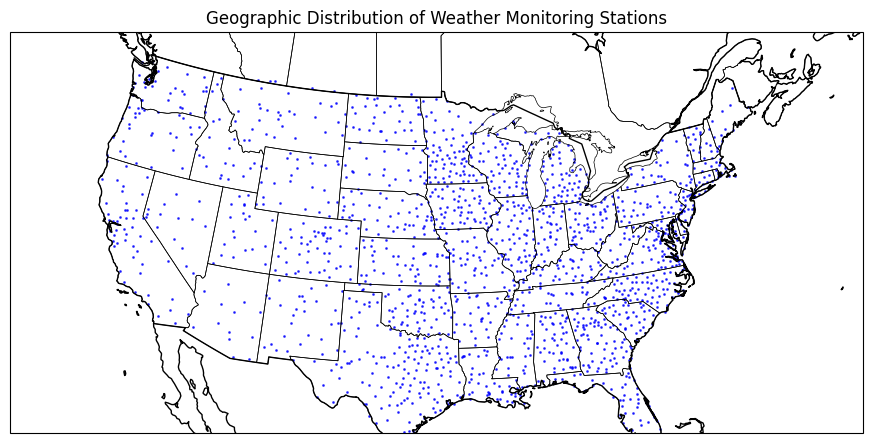

In [24]:
# Extract informations
stations_coords = df_daily_weather[['STATION', 'LATITUDE', 'LONGITUDE']].drop_duplicates().values

# Plot points on map
print_points_on_us_map(latitudes=stations_coords[:, 1],
                       longitudes=stations_coords[:, 2],
                       title="Geographic Distribution of Weather Monitoring Stations",
                      )

### Prepare the merge with df
> To avoid data leakage, we don't want to merge on daily date. Instead, for a day D in df, we will add the information of day D-1 in df_weather.

In [25]:
# Drop columns that proved to be useless as features
cols = ['RainPrecipitation', 'Flag_Thunder']
df_daily_weather.drop(columns=cols, inplace=True)

# Show
print(df_daily_weather.shape)
df_daily_weather.head(1)

(5610098, 6)


STATION        date   LATITUDE   LONGITUDE  Temperature  MaxWindSpeed
0  69015093121  2015-01-01  34.293999 -116.147217         37.2           8.0

In [26]:
cols_to_shift = ['Temperature',
                 'MaxWindSpeed',
                 ]

# Replace information of day D by the information on day D-1
for k in cols_to_shift:
    df_daily_weather[f"{k}_1day_before"] = df_daily_weather.groupby('STATION')[k].shift(1)

# Compute rolling feats
for k in cols_to_shift:
    for n_days in [3]:
        df_daily_weather[f"Max_{k}_over_{n_days}last_days"]  = np.round(df_daily_weather.groupby('STATION')[k].rolling(n_days).max().values, 1)
        df_daily_weather[f"Mean_{k}_over_{n_days}last_days"] = np.round(df_daily_weather.groupby('STATION')[k].rolling(n_days).mean().values, 1)

# Drop columns of current date (that might introduce data leakage)
df_daily_weather.drop(columns=cols_to_shift + ['LATITUDE', 'LONGITUDE'], inplace=True)

# Drop NaN
df_daily_weather.dropna(inplace=True)

# Show
print(df_daily_weather.shape)
df_daily_weather.head()

(5606462, 8)


STATION        date  Temperature_1day_before  MaxWindSpeed_1day_before  \
2  69015093121  2015-01-03                     36.4                       9.9   
3  69015093121  2015-01-04                     40.1                       8.9   
4  69015093121  2015-01-05                     41.0                       8.9   
5  69015093121  2015-01-06                     45.8                      11.1   
6  69015093121  2015-01-07                     50.2                       9.9   

   Max_Temperature_over_3last_days  Mean_Temperature_over_3last_days  \
2                             40.1                              37.9   
3                             41.0                              39.2   
4                             45.8                              42.3   
5                             50.2                              45.7   
6                             54.7                              50.2   

   Max_MaxWindSpeed_over_3last_days  Mean_MaxWindSpeed_over_3last_days  
2                               9.9                                8.9  
3                               9.9                                9.2  
4                              11.1                                9.6  
5                              11.1                               10.0  
6                              11.1                               10.3

### Merge with df

In [27]:
# Open the dictionnary containing the closest station to each fips
dict_closest_station_to_fips = joblib.load(filepath_dict_closest_station)

# Create a column in df to merge
df['STATION'] = df['fips'].map(dict_closest_station_to_fips)

# Join
df = pd.merge(df,
              df_daily_weather,
              how = 'left',
              on = ['STATION', 'date'],
             )

# Drop column 'STATION'
df = df.drop(columns = ['STATION'])

# Show
print(df.shape)
df.head()

(4268242, 20)


fips        date  month  week  dayofweek  hour  outages  envelop  \
0  1001  2023-11-01     11    44          2     0      4.0      NaN   
1  1001  2023-11-01     11    44          2     1      5.0      NaN   
2  1001  2023-11-01     11    44          2     2      6.0      0.0   
3  1001  2023-11-01     11    44          2     3      4.0      0.0   
4  1001  2023-11-01     11    44          2     4      0.0      0.0   

   outages_outbreak  flag_more_than_50_outages  \
0               0.0                          0   
1               0.0                          0   
2               0.0                          0   
3               0.0                          0   
4               0.0                          0   

   Proportion_of_fips_within_300km_with_more_than_50_outages  \
0                                           0.011299           
1                                           0.016949           
2                                           0.022599           
3                                           0.022599           
4                                           0.022599           

   Proportion_of_fips_within_600km_with_more_than_50_outages  \
0                                           0.015723           
1                                           0.015723           
2                                           0.025157           
3                                           0.022013           
4                                           0.017296           

   max_Proportion_of_fips_within_300km_with_more_than_50_outages_over_last_24hours  \
0                                                0.0                                 
1                                                0.0                                 
2                                                0.0                                 
3                                                0.0                                 
4                                                0.0                                 

   max_Proportion_of_fips_within_600km_with_more_than_50_outages_over_last_24hours  \
0                                                0.0                                 
1                                                0.0                                 
2                                                0.0                                 
3                                                0.0                                 
4                                                0.0                                 

   Temperature_1day_before  MaxWindSpeed_1day_before  \
0                     51.8                      10.9   
1                     51.8                      10.9   
2                     51.8                      10.9   
3                     51.8                      10.9   
4                     51.8                      10.9   

   Max_Temperature_over_3last_days  Mean_Temperature_over_3last_days  \
0                             63.9                              53.4   
1                             63.9                              53.4   
2                             63.9                              53.4   
3                             63.9                              53.4   
4                             63.9                              53.4   

   Max_MaxWindSpeed_over_3last_days  Mean_MaxWindSpeed_over_3last_days  
0                              13.0                               11.0  
1                              13.0                               11.0  
2                              13.0                               11.0  
3                              13.0                               11.0  
4                              13.0                               11.0

In [28]:
# Optimize df columns' types to reduce memory usage, to avoid out-of-memory errors on low-RAM environments
df = reduce_memory_usage(df)

BEFORE: Memory usage of dataframe is 533.20 MB
AFTER: Memory usage became:  203.5  MB


___
___
# <span style="color:#0096FF;">**Part 6: Add Storm Events.**</span>

### **Goal**
- Incorporate storm-related context to account for severe weather events that can cause or amplify outages.
  
### *Data source:*
- NOAA (provided by the competition host).

___
## <span style="color:#A7C7E7;">**<u>Step 1:</u></span> Open STORMS data.**
> - We use aggregated STORMS data, with one row per date (hourly) and fips. 
> - This df is the output of the notebook `1b. STORMS`.

In [29]:
%%time

# Open df_by_fips_and_hours
df_by_fips_and_hours = pd.read_csv(storms_data_filepath)

# Reduce memory usage by converting column types
df_by_fips_and_hours = reduce_memory_usage(df_by_fips_and_hours)

# Convert to datetime
df_by_fips_and_hours['date'] = pd.to_datetime(df_by_fips_and_hours['date'])

# Show
print(df_by_fips_and_hours.shape)
df_by_fips_and_hours.head(1)

BEFORE: Memory usage of dataframe is 344.30 MB
AFTER: Memory usage became:  91.1  MB
(2654912, 17)
CPU times: user 4.02 s, sys: 784 ms, total: 4.8 s
Wall time: 6.08 s


fips       date  Count_Other_light  Count_Other_moderate  \
0  1001 2023-11-01                0.0                   0.0   

   Count_Other_severe  Count_Wind  MAGNITUDE  WORDS_wind_and_storm  \
0                 1.0         0.0        0.0                     0   

   WORDS_downed_trees  WORDS_heavy_damage  WORDS_wires  WORDS_water_and_flood  \
0                   0                   1            0                      1   

   WORDS_heat_and_fire  WORDS_snow  Count_Flood  Count_Storm  Count_Fire  
0                    3           0          0.0          0.0         0.0

___
## <span style="color:#A7C7E7;">**<u>Step 2:</u></span> Join STORMS data to our df.**
By FIPS and date.


In [30]:
%%time

# Create datetime col
df['date'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# Merge
df = pd.merge(df,
              df_by_fips_and_hours,
              how = 'left',
              on = ['fips', 'date'],
              )

# Create a column summing all sever events
cols = ['Count_Other_severe', 'Count_Storm', 'Count_Wind', 'Count_Flood', 'Count_Fire']
df['Severe_events_count'] = df[cols].fillna(0).sum(axis=1)

# Convert back to string
df["date"] = df["date"].astype(str).apply(lambda x : x[:10])

# Show
print(df.shape)
df.head(1)

(4268242, 36)
CPU times: user 12.3 s, sys: 1.54 s, total: 13.8 s
Wall time: 13.7 s


fips        date  month  week  dayofweek  hour  outages  envelop  \
0  1001  2023-11-01     11  44.0          2     0      4.0      NaN   

   outages_outbreak  flag_more_than_50_outages  ...  WORDS_downed_trees  \
0               0.0                          0  ...                 0.0   

   WORDS_heavy_damage  WORDS_wires  WORDS_water_and_flood  \
0                 1.0          0.0                    1.0   

   WORDS_heat_and_fire  WORDS_snow  Count_Flood  Count_Storm  Count_Fire  \
0                  3.0         0.0          0.0          0.0         0.0   

   Severe_events_count  
0                  1.0  

[1 rows x 36 columns]

In [31]:
# Delete object to save memory
del df_by_fips_and_hours

_ = gc.collect()

___
## <span style="color:#A7C7E7;">**<u>Step 3:</u></span> Let's observe the correlation between weather events and power outages !**
> - The correlation matrix shows little correlations between outages and weather events.
> - However, the matrix coefficients can vary significantly depending on the time of year and the specific counties analyzed.

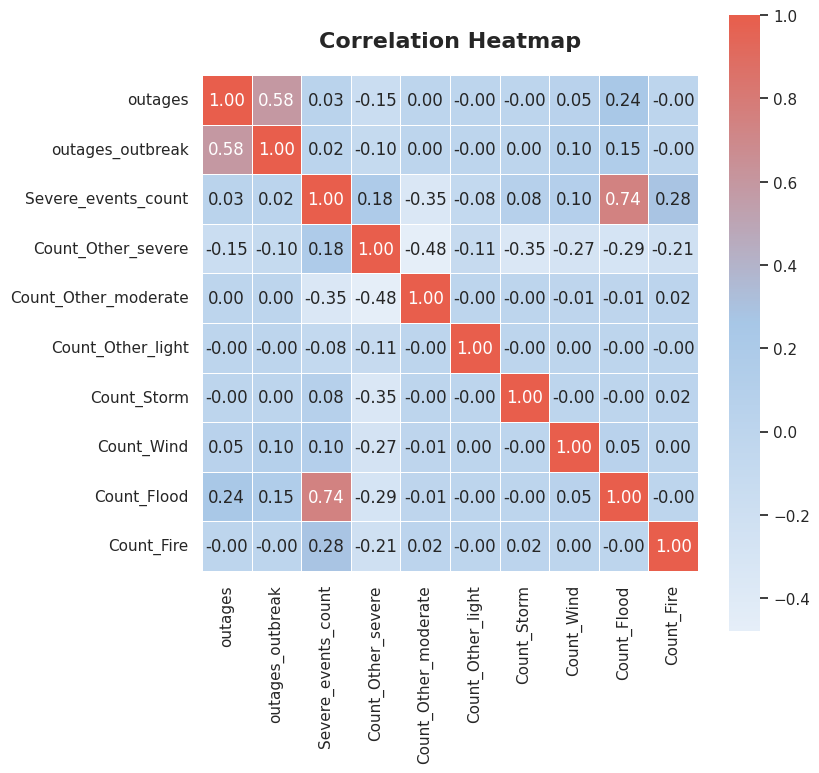

In [32]:
# Plot correlation matrix
plot_correlation_matrix(df, cols=['outages',
                                  'outages_outbreak',
                                  'Severe_events_count',
                                  'Count_Other_severe',
                                  'Count_Other_moderate',
                                  'Count_Other_light',
                                  'Count_Storm',
                                  'Count_Wind',
                                  'Count_Flood',
                                  'Count_Fire', 
                                 ], figsize=(8, 8))

#### For <span style="color:yellow;">FIPS n°33007</span>, we can see some outages starting right after some severe weather events (Tornado, Floods, Storms ...).
However, no weather events was reported on 2023-12-11. But we will see that some have been reported in the adjacent counties!

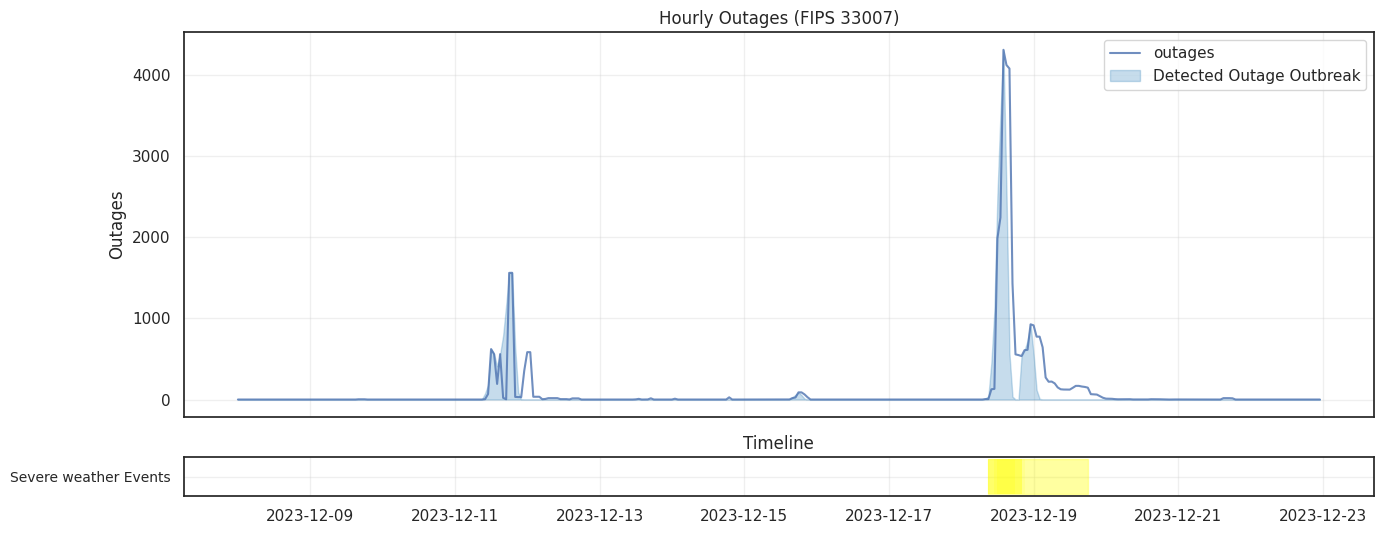

In [33]:
# Show outages for fips n°33007 (Coos County - Oregon)
plot_peaks(df,
       fips=33007,
       cols_to_plot=['outages', 'outages_outbreak'],
       cols_timeline=['Severe_events_count',],
       start_date = '2023-12-08',
       end_date   = '2023-12-22',
      )

#### In the next part, we will focus on the weather events that occured in the neighbourhood of a fips. The idea is that severe events may often have happended several hours sooner there !

___
___
# <span style="color:#0096FF;">**Part 7: Add demographic data.**</span>

### **Goal**
- Add county population, land & water areas to capture demographic factors that may influence outage impact and infrastructure resilience.
  
### *Data source:*
- https://seer.cancer.gov/popdata/download.html

___
## <span style="color:#A7C7E7;">**<u>Step 1:</u></span> Add county informations.**
LandArea & WaterArea of neighbours

In [34]:
# Create a DataFrame from dict_fips
dict_fips_df = pd.DataFrame.from_dict(dict_fips, orient='index').reset_index().rename(columns={'index': 'fips'})

# Drop list columns
dict_fips_df.drop(columns = ['name', 'neighbours_1st', 'neighbours_2nd', 'neighbours_3rd', 'neighbours_4th', 'far_neighbours'], inplace=True)

# Useful columns to add in df
cols = ['LandArea', 'WaterArea', 'latitude', 'longitude']

# Merge on df
df = pd.merge(df,
              dict_fips_df[['fips'] + cols],
              how = 'left',
              on = 'fips',
             )

# Fill NaN
for x in ['latitude', 'longitude']:
    df[x] = df[x].fillna(df[x].mean())

# Show
print(dict_fips_df.shape)
dict_fips_df.head()

(3233, 13)


fips   latitude  longitude  LandArea  WaterArea  LandArea_neighbours_1st  \
0   1059  34.442381 -87.843283      1642         33                   9315.0   
1  13111  34.864126 -84.319296      1003         13                   6415.0   
2  19109  43.204140 -94.206898      2519          4                  12814.0   
3  40115  36.835878 -94.810589      1219         36                  11746.0   
4  42115  41.821277 -75.800905      2133         22                  13978.0   

   WaterArea_neighbours_1st  LandArea_neighbours_2nd  \
0                     272.0                  20038.0   
1                      97.0                  15522.0   
2                     120.0                  25218.0   
3                     186.0                  25524.0   
4                     236.0                  36458.0   

   WaterArea_neighbours_2nd  LandArea_neighbours_3rd  \
0                     490.0                  33331.0   
1                     361.0                  30771.0   
2                     325.0                  34923.0   
3                     560.0                  40522.0   
4                     600.0                  46853.0   

   WaterArea_neighbours_3rd  LandArea_neighbours_4th  WaterArea_neighbours_4th  
0                     475.0                  48369.0                     821.0  
1                     850.0                  43459.0                    1127.0  
2                     289.0                  49218.0                     417.0  
3                     893.0                  56295.0                    1428.0  
4                    1589.0                  69481.0                    7106.0

___
## <span style="color:#A7C7E7;">**<u>Step 2:</u></span> Add counties populations (external data).**
- Source for external data : https://seer.cancer.gov/popdata/download.html

In [35]:
%%time

# Read file containing population data
df_state  = read_txt_line_by_line(population_filepath)

# Create a coopy without 'state' column
df_county = df_state.drop(columns = ['state'])

# Show
print(df_county.shape)
df_county.head()

17131809it [00:20, 825444.26it/s]


(3500233, 4)
CPU times: user 22.2 s, sys: 1.72 s, total: 23.9 s
Wall time: 24.8 s


year  fips  Age  Population
0  2014  1001    0         251
1  2014  1001    1        1048
2  2014  1001    2        1500
3  2014  1001    3        1648
4  2014  1001    4        1604

In [36]:
# Mapping to decode the age column from the file
age_mapping = {
        0: "Age_0_14", 1: "Age_0_14", 2: "Age_0_14", 3: "Age_0_14",
        4: "Age_14_24", 5: "Age_14_24",
        6: "Age_24_39", 7: "Age_24_39",
        8: "Age_39_64", 9: "Age_39_64", 10: "Age_39_64",
        11: "Age_64_plus", 12: "Age_64_plus", 13: "Age_64_plus", 14: "Age_64_plus", 
        15: "Age_64_plus", 16: "Age_64_plus", 17: "Age_64_plus", 18: "Age_64_plus", 19: "Age_64_plus"
    }

# Apply mapping
df_county['Age_category'] = df_county['Age'].astype(int).map(age_mapping)

# Pivot to have one column per age
df_county = df_county.pivot_table(index=['year', 'fips'], 
                                  columns='Age_category', 
                                  values='Population', 
                                  aggfunc='sum', 
                                  fill_value=0)

# Compute total population across all ages
df_county['Population'] = df_county.sum(axis=1)

# Divide all columns to have proportions
age_cols = [x for x in df_county.columns if x.startswith('Age')]
for col in age_cols :
    df_county[col] = df_county[col] / df_county['Population']

# Reset index for a clean DataFrame
df_county = df_county.reset_index()
df_county.columns.name = None

# Create ponderated age
df_county['Age'] = 7 * df_county['Age_0_14'] + \
                   19 * df_county['Age_14_24'] + \
                   29.5 * df_county['Age_24_39'] + \
                   51.5 * df_county['Age_39_64'] + \
                   75 * df_county['Age_64_plus']

# Show
print(df_county.shape)
df_county.head()

(31420, 9)


year  fips  Age_0_14  Age_14_24  Age_24_39  Age_39_64  Age_64_plus  \
0  2014  1001  0.203159   0.135618   0.121571   0.210888     0.328764   
1  2014  1003  0.184726   0.116703   0.113195   0.190889     0.394487   
2  2014  1005  0.180772   0.123589   0.141186   0.191507     0.362945   
3  2014  1007  0.172145   0.124107   0.142471   0.215037     0.346241   
4  2014  1009  0.194863   0.124460   0.114468   0.199152     0.367057   

   Population        Age  
0       56025  43.103222  
1      200724  46.266996  
2       27106  44.862134  
3       22545  44.808383  
4       58051  44.891182

(4268242, 43)


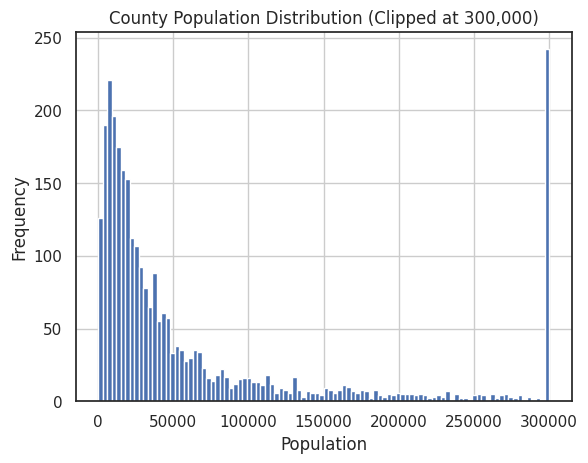

CPU times: user 2.52 s, sys: 542 ms, total: 3.06 s
Wall time: 3.06 s


In [37]:
%%time

df["year"] = df["date"].apply(lambda x : x[:4]).astype(int)

# Merge
df = pd.merge(df,
              df_county[['year', 'fips', 'Age', 'Population']],
              how='left',
              on=['year', 'fips'])

# Show
print(df.shape)
populations = df.groupby('fips')['Population'].max().sort_values()
populations.clip(0, 300000).hist(bins=100)
plt.title('County Population Distribution (Clipped at 300,000)')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()

In [38]:
# Delete object to save memory
del df_county, df_state

_ = gc.collect()

___
___
# <span style="color:#0096FF;">**Part 8: Add state-level data.**</span>

### **Goal**
- Add aggregated and rolling features from state-level data to capture regional trends and local outage behaviors.

In [39]:
# Get states from fips first 2 caracters
df['state'] = df['fips'].astype(str).apply(lambda x : x.zfill(5)[:2]).map(state_by_fips)

# Show state repartition
df['state'].astype(str).value_counts().to_frame()

count
state        
TX     363132
GA     227678
VA     181566
KY     172920
MO     164274
IL     146982
NC     144100
IA     142659
KS     131131
IN     131131
OH     126808
MI     119603
TN     116721
MN     113839
MS     110957
OK     110957
AR     106634
WI     103752
FL      96547
PA      96547
AL      93665
LA      92224
NY      89342
CA      83578
SD      83578
WV      79255
NE      72050
CO      69168
SC      66286
MT      66286
ID      61963
ND      60522
OR      50435
WA      47553
NM      38907
UT      36025
MD      34584
WY      30261
NJ      30261
ME      23056
NV      21615
MA      20174
VT      20174
AZ      20174
NH      14410
nan     12969
AK      11528
CT      11528
RI       7205
HI       5764
DE       4323
DC       1441

In [40]:
%%time

# Add data from states
df = add_data_from_states(df)

# Show
print(df.shape)
df.head(1)

(4268242, 61)
CPU times: user 3.65 s, sys: 1.64 s, total: 5.28 s
Wall time: 5.29 s


fips        date  month  week  dayofweek  hour  outages  envelop  \
0  1001  2023-11-01     11  44.0          2     0      4.0      NaN   

   outages_outbreak  flag_more_than_50_outages  ...  \
0               0.0                          0  ...   

   max_state_fips_with_more_than_50_outages_over_last_6hours  \
0                                                0.0           

   proportion_state_fips_with_more_than_50_outages_over_last_6hours  \
0                                                0.0                  

   max_state_fips_with_more_than_50_outages_over_last_24hours  \
0                                                0.0            

   proportion_state_fips_with_more_than_50_outages_over_last_24hours  \
0                                                0.0                   

   SUM_BY_STATE_Severe_events_count_sum_by_state_last_24hours  \
0                                                0.0            

   SUM_BY_STATE_WORDS_wind_and_storm_sum_by_state_last_24hours  \
0                                                0.0             

   SUM_BY_STATE_WORDS_downed_trees_sum_by_state_last_24hours  \
0                                                0.0           

   SUM_BY_STATE_WORDS_heavy_damage_sum_by_state_last_24hours  \
0                                                0.0           

   SUM_BY_STATE_WORDS_wires_sum_by_state_last_24hours  \
0                                                0.0    

   SUM_BY_STATE_state_fips_with_more_than_50_outages_last_24hours  
0                                                0.0               

[1 rows x 61 columns]

___
___
# <span style="color:#0096FF;">**Part 9: Find Outages Fronts.**</span>

### **Goal**
- Detect spatiotemporal outage waves, determine their centroids, and trace their points of origin to better understand the dynamics and spread of large-scale disruption events.

___
## **Outages Fronts**

#### <u>1st step:</u> for each timestep, create clusters of outages with DBSCAN and compute their centroïds.

In [41]:
%%time

# 1st step : for each timesteps (hour), create clusters of outages with DBSCAN, and compute their centroïds
centroids_outages = compute_centroids(df,
                                      col='outages',
                                      threshold=100, # outages
                                      dbscan_eps=0.9, # ~11km per 0.1 eps
                                      dbscan_min_samples=4)

# Show an example of output
centroids_outages['2023-12-18 12:00:00'][0] # latitude, longitude, width, height, angle, numbers

100%|██████████| 1441/1441 [00:08<00:00, 169.11it/s]

CPU times: user 12.8 s, sys: 6.05 s, total: 18.8 s
Wall time: 19.1 s


{'lat': 41.493147,
 'lon': -73.05623,
 'width': 8.171338,
 'height': 2.013121,
 'angle': 56.351167,
 'weights': 2303.8877,
 'cluster_size': 129}

#### <u>2nd step:</u> track centroïds movements.

In [42]:
%%time

# Get vectors for centroïds evolution
vectors_outages = get_centroids_evolution(centroids_outages,  max_km=110)

# Show an example of output
vectors_outages['2023-12-18 12:00:00'][0]

CPU times: user 5.86 s, sys: 291 µs, total: 5.86 s
Wall time: 5.87 s


{'lat': 41.493147,
 'lon': -73.05623,
 'lat_diff': 0.314136,
 'lon_diff': 0.369605,
 'width': 8.171338,
 'height': 2.013121,
 'angle': 56.351167,
 'weights_diff': 1488.0,
 'weights': 2303.8877,
 'cluster_size': 129,
 'cluster_size_diff': 125}

## Let's show the results on a map !
- **<u>Arrow length :</u>** Speed of the cluster movement
- **<u>Arrow size   :</u>** Size of the event (visible with plot_ellipses=True)
- **<u>Arrow color  :</u>** Severity of the event (the more severe, the darker the color)

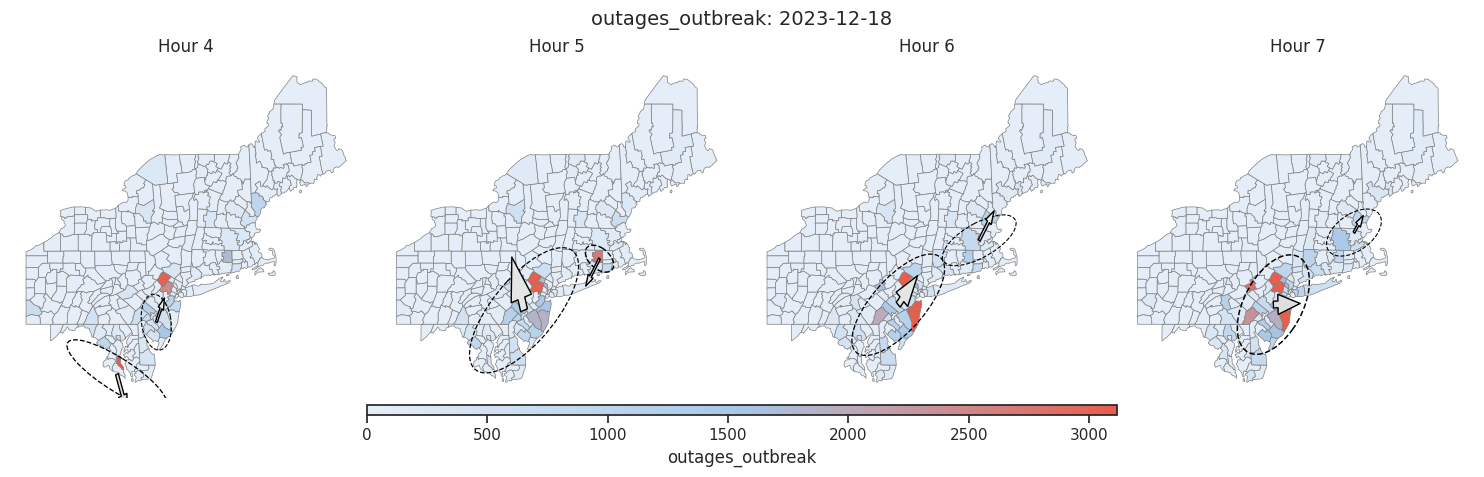

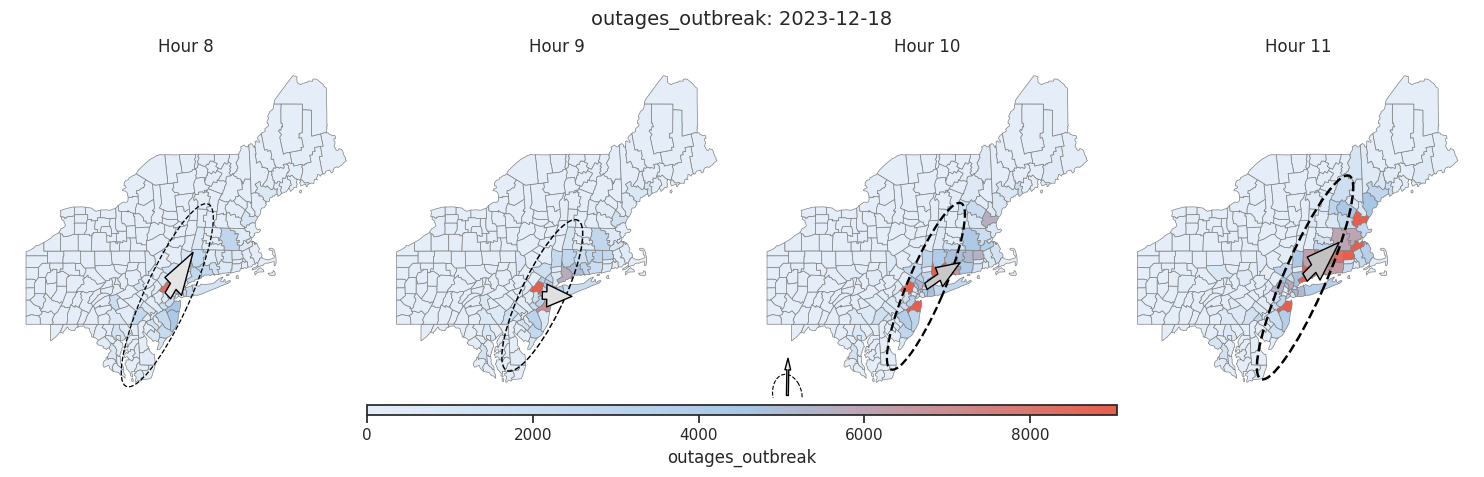

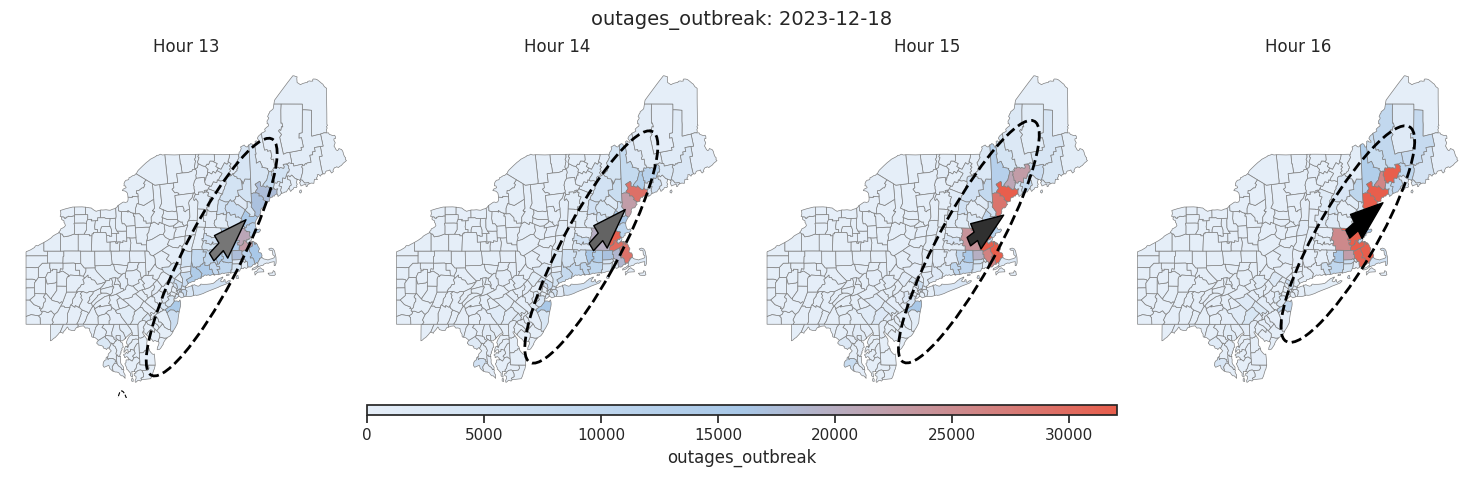

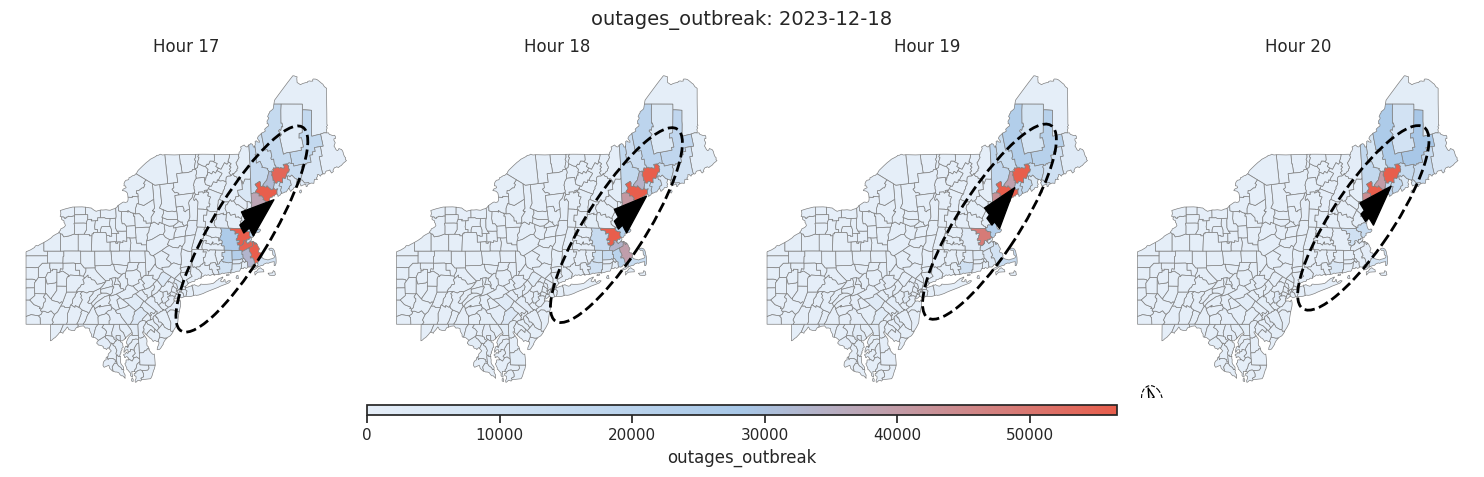

In [43]:
"""
- Arrow length : Speed of the cluster movement
- Arrow size   : Size of the event (visible with plot_ellipses=True)
- Arrow color  : Severity of the event (the more severe, the darker the color)
"""

# Plot outages evolution with arrows and ellipse
plot_evolution(df,
               date= '2023-12-18',
               hours_list = [4, 5, 6, 7],
               vectors = vectors_outages,
               fips = north_east_fips,
               color_by="outages_outbreak",
               figsize=(15, 5),
               plot_ellipses=True,
              )

# Plot outages evolution with arrows and ellipse
plot_evolution(df,
               date= '2023-12-18',
               hours_list = [8, 9, 10, 11],
               vectors = vectors_outages,
               fips = north_east_fips,
               color_by="outages_outbreak",
               figsize=(15, 5),
               plot_ellipses=True,
              )

# Plot outages evolution with arrows and ellipse
plot_evolution(df,
               date= '2023-12-18',
               hours_list = [13, 14, 15, 16],
               vectors = vectors_outages,
               fips = north_east_fips,
               color_by="outages_outbreak",
               figsize=(15, 5),
               plot_ellipses=True,
              )


# Plot outages evolution with arrows and ellipse
plot_evolution(df,
               date= '2023-12-18',
               hours_list = [17, 18, 19, 20],
               vectors = vectors_outages,
               fips = north_east_fips,
               color_by="outages_outbreak",
               figsize=(15, 5),
               plot_ellipses=True,
              )

## **A Clear Visualization of Outage Evolution (Hour-by-Hour Timelapse)**

#### <span style="color:#FF2C2C;">⚠️ <u>Warning:</u> The output of this cell may be heavy (~20MB) and could cause the saved notebook to crash. For safety, the code is commented out — but I strongly recommend uncommenting it and trying it yourself!

- This timelapse visualizes outages hour by hour at the county level, making the progression of the disruptions easy to track.
- In the example below, consider focusing on the **northeastern region (New York, Connecticut…)**, where a major outage spread rapidly around **December 18, 2023**.


In [44]:
# PLEASE UNCOMMENT THE CODE BELOW TO SEE A NICE VIZUALISATION TOOL !

# Plot hourly timelapse of outages (commented to avoid the saved notebook to crash)
"""
plot_timelapse(df,
               col='outages',
               start_date = '2023-12-18',
               end_date = '2023-12-19',
               )
"""

"\nplot_timelapse(df,\n               col='outages',\n               start_date = '2023-12-18',\n               end_date = '2023-12-19',\n               )\n"

___
___
# <span style="color:#0096FF;">**Part 10: Forecast where Outages Fronts will hit in the next hours.**</span>

### **Goal**
- Leverage the detected outage fronts to forecast their short-term trajectory, anticipate the counties likely to be affected next, and estimate the potential severity of impact.

In [45]:
# Add estimation of impacted zone in 3 and 6 hours
df = forecast_hit_zone_of_vectors(df, df_latlong, vectors_outages, dict_fips=dict_fips)

# Show
print(df.shape)
df.head(1)

100%|██████████| 1441/1441 [01:09<00:00, 20.67it/s]


(4268242, 71)


fips        date  month  week  dayofweek  hour  outages  envelop  \
0  1001  2023-11-01     11  44.0          2     0      4.0      NaN   

   outages_outbreak  flag_more_than_50_outages  ...  \
0               0.0                          0  ...   

   projected_distance_to_centroid_center_in_3hours  vector_weights  \
0                                              NaN             NaN   

   vector_weights_diff  vector_cluster_size  vector_cluster_size_diff  \
0                  NaN                  NaN                       NaN   

   projected_fips_impacted_in_3hours  projected_impact_in_3hours  \
0                                NaN                         NaN   

   projected_distance_to_centroid_center_in_6hours  \
0                                              NaN   

   projected_fips_impacted_in_6hours  projected_impact_in_6hours  
0                                NaN                         NaN  

[1 rows x 71 columns]

#### Below, we can see that the column "projected impact in 6 hours" seems to be a good forecasting indicator of outages outbreak


At 10:00 AM, we analyzed the situation and estimated the movement of outages across the region.
The computed vectors revealed a clear propagation pattern toward the northeast:


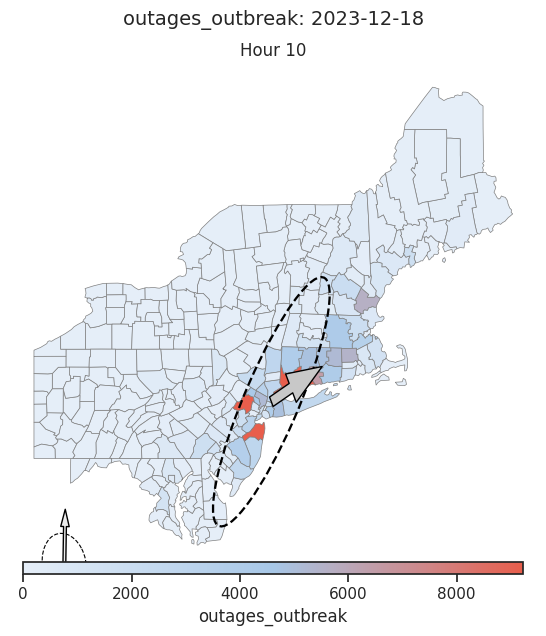


Based on this dynamic, we estimated (at 10:00 AM) that the affected impact zone will look like this 6 hours later, at 4:00 PM:


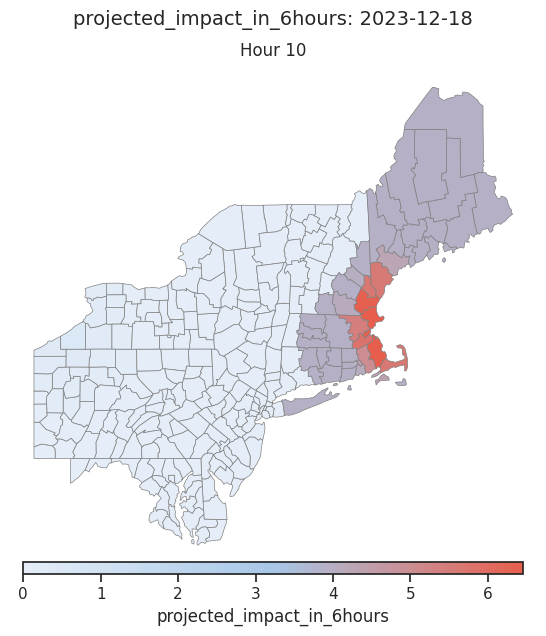


Finally, here is the actual situation at 4:00 PM, allowing us to assess the accuracy of our forecast:


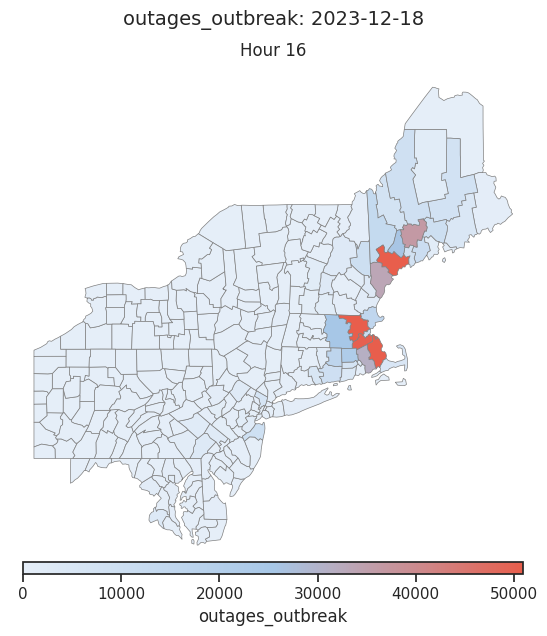

In [46]:
print("\nAt 10:00 AM, we analyzed the situation and estimated the movement of outages across the region.")
print("The computed vectors revealed a clear propagation pattern toward the northeast:")
plot_evolution(df,
               date= '2023-12-18',
               hours_list = [10],
               vectors = vectors_outages,
               fips = north_east_fips,
               color_by="outages_outbreak",
               fillna_value=0,
               figsize=(10, 6),
               plot_ellipses=True,
              )

print("\nBased on this dynamic, we estimated (at 10:00 AM) that the affected impact zone will look like this 6 hours later, at 4:00 PM:")
# Plot outages evolution with arrows
plot_evolution(df,
               date= '2023-12-18',
               hours_list = [10],
               #vectors = vectors_outages,
               fips = north_east_fips,
               color_by="projected_impact_in_6hours",
               fillna_value=0,
               figsize=(10, 6),
               #plot_ellipses=True,
              )

print("\nFinally, here is the actual situation at 4:00 PM, allowing us to assess the accuracy of our forecast:")
plot_evolution(df,
               date= '2023-12-18',
               hours_list = [16],
               #vectors = vectors_outages,
               fips = north_east_fips,
               color_by="outages_outbreak",
               fillna_value=0,
               figsize=(10, 6),
               plot_ellipses=True,
              )

### Let's plot the evolution of projections (upper graphs) compared to true outages 6 hours later (lower graphs)

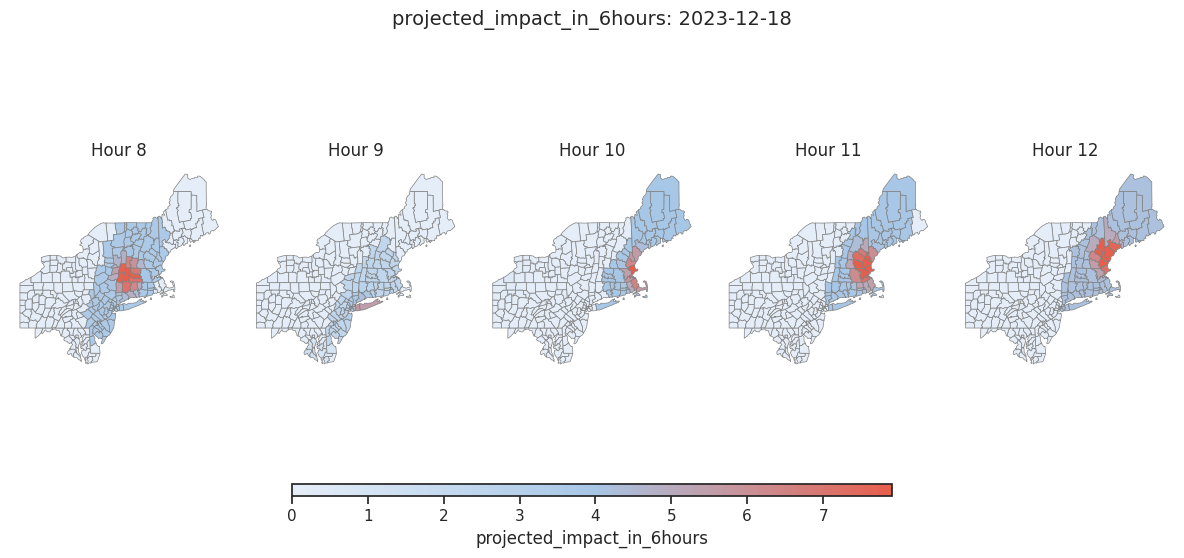

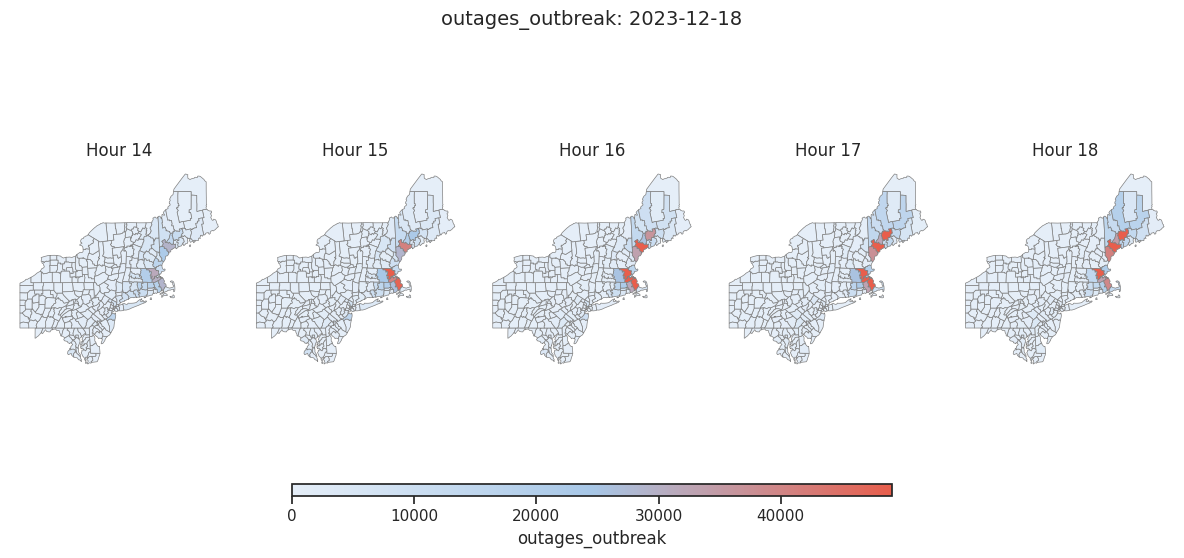

In [47]:
# Projections
plot_evolution(df,
               date= '2023-12-18',
               hours_list = [8, 9, 10, 11, 12],
               #vectors = vectors_outages,
               fips = north_east_fips,
               color_by="projected_impact_in_6hours",
               fillna_value=0,
               figsize=(12, 6),
               #plot_ellipses=True,
              )

# True outages
plot_evolution(df,
               date= '2023-12-18',
               hours_list = [14, 15, 16, 17, 18],
               #vectors = vectors_outages,
               fips = north_east_fips,
               color_by="outages_outbreak",
               fillna_value=0,
               figsize=(12, 6),
               plot_ellipses=True,
              )

### Finally, let’s visualize the correlation between projected impact and actual outages in selected counties.

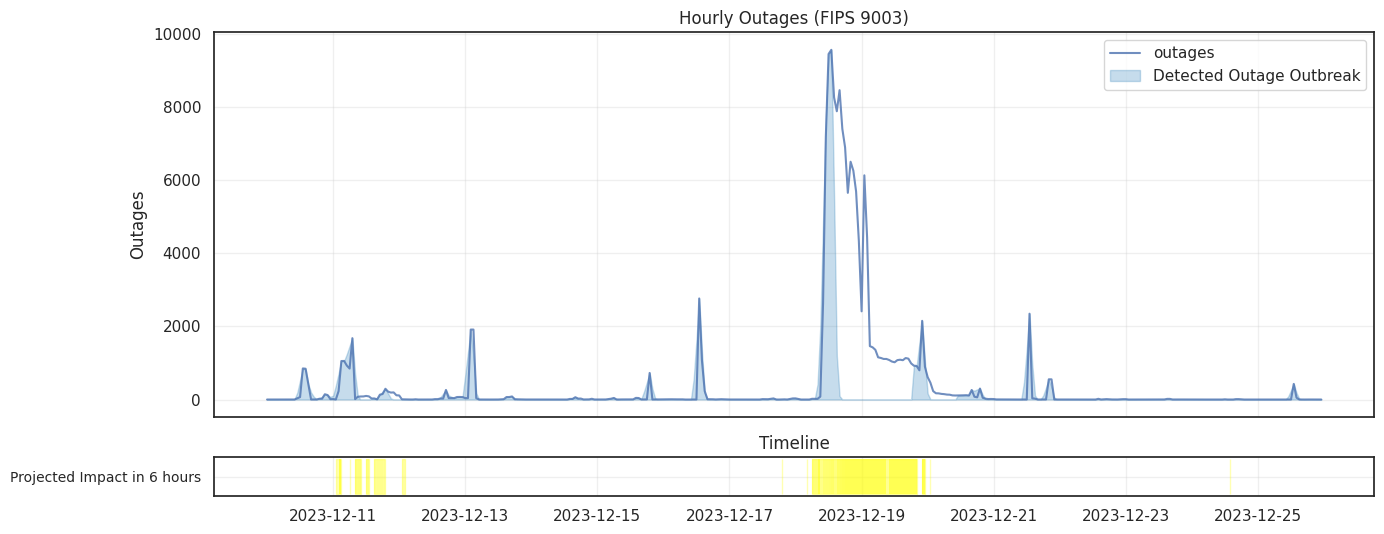

In [48]:
# Show outages for fips n°9003 (Hartford - Connecticut)
plot_peaks(df,
           fips=9003,
           cols_to_plot=['outages', 'outages_outbreak'],
           cols_timeline=['projected_impact_in_6hours'],
           start_date = '2023-12-10',
           end_date   = '2023-12-25',
          )

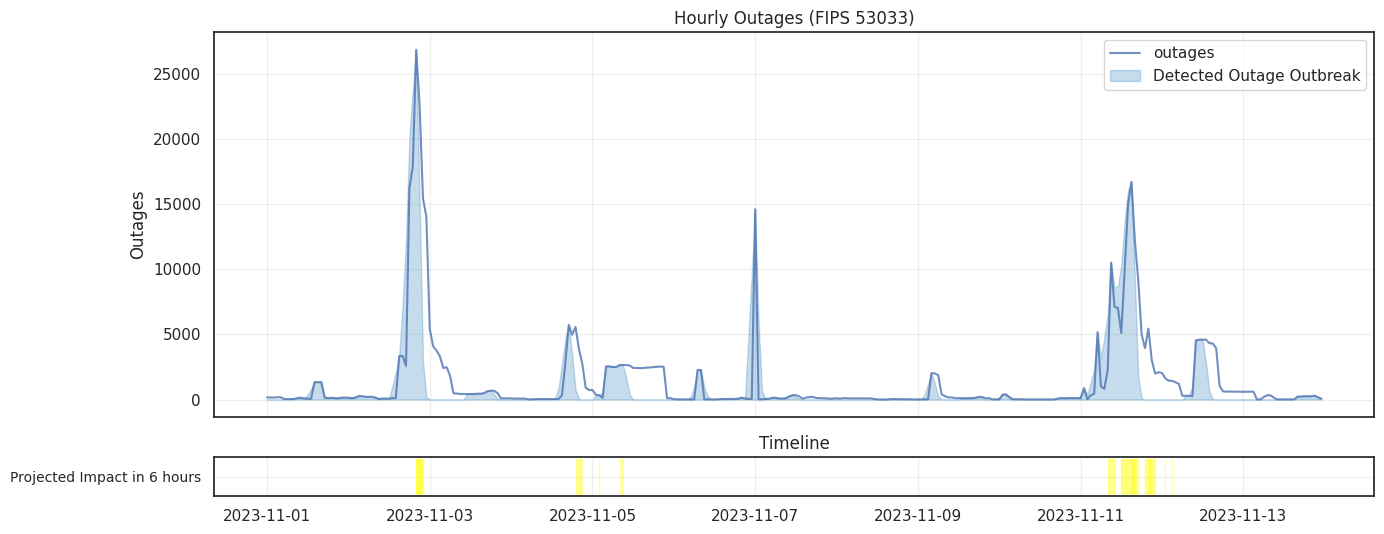

In [49]:
# Show outages for fips n°53033 (King County - Washington)
plot_peaks(df,
           fips=53033,
           cols_to_plot=['outages', 'outages_outbreak'],
           cols_timeline=['projected_impact_in_6hours'],
           start_date = '2023-11-01',
           end_date   = '2023-11-13'
          )

___
___
# <span style="color:#0096FF;">**Part 11: Add Neighbours Storm Events.**</span>

### **Goal**
- Enrich each county’s data with storm events from neighboring counties to capture broader weather influences.

___
## <span style="color:#A7C7E7;">**<u>Step 1:</u></span> Add neighbourhood data**

In [50]:
%%time

# Compute aggregated features from neighboring FIPS codes
df = add_data_from_neighbours(df, dict_fips)

# Show
print(df.shape)
df.head()

100%|██████████| 2962/2962 [03:53<00:00, 12.69it/s]


(4268242, 164)
CPU times: user 11min 19s, sys: 1min 23s, total: 12min 42s
Wall time: 12min 39s


fips        date  month  week  dayofweek  hour  outages  envelop  \
1001  1001  2023-11-01     11  44.0          2     0      4.0      NaN   
1001  1001  2023-11-01     11  44.0          2     1      5.0      NaN   
1001  1001  2023-11-01     11  44.0          2     2      6.0      0.0   
1001  1001  2023-11-01     11  44.0          2     3      4.0      0.0   
1001  1001  2023-11-01     11  44.0          2     4      0.0      0.0   

      outages_outbreak  flag_more_than_50_outages  ...  \
1001               0.0                          0  ...   
1001               0.0                          0  ...   
1001               0.0                          0  ...   
1001               0.0                          0  ...   
1001               0.0                          0  ...   

      WORDS_heavy_damage_sum_among_ALL_neighbours  \
1001                                         18.0   
1001                                         18.0   
1001                                         18.0   
1001                                         18.0   
1001                                         18.0   

      WORDS_wires_sum_among_ALL_neighbours  \
1001                                   0.0   
1001                                   0.0   
1001                                   0.0   
1001                                   0.0   
1001                                   0.0   

      WORDS_heat_and_fire_sum_among_ALL_neighbours  \
1001                                          25.0   
1001                                          25.0   
1001                                          25.0   
1001                                          25.0   
1001                                          25.0   

      Count_Other_light_sum_among_ALL_neighbours  \
1001                                         0.0   
1001                                         0.0   
1001                                         0.0   
1001                                         0.0   
1001                                         0.0   

      Count_Other_moderate_sum_among_ALL_neighbours  \
1001                                            0.0   
1001                                            0.0   
1001                                            0.0   
1001                                            0.0   
1001                                            0.0   

      Count_Other_severe_sum_among_ALL_neighbours  \
1001                                         16.0   
1001                                         16.0   
1001                                         21.0   
1001                                         21.0   
1001                                         21.0   

      Count_Flood_sum_among_ALL_neighbours  \
1001                                   0.0   
1001                                   0.0   
1001                                   0.0   
1001                                   0.0   
1001                                   0.0   

      Count_Storm_sum_among_ALL_neighbours  \
1001                                   0.0   
1001                                   0.0   
1001                                   0.0   
1001                                   0.0   
1001                                   0.0   

      Count_Wind_sum_among_ALL_neighbours  Count_Fire_sum_among_ALL_neighbours  
1001                                  0.0                                  0.0  
1001                                  0.0                                  0.0  
1001                                  0.0                                  0.0  
1001                                  0.0                                  0.0  
1001                                  0.0                                  0.0  

[5 rows x 164 columns]

___
## <span style="color:#A7C7E7;">**<u>Step 2:</u></span> Visualize some weather events**


### For <span style="color:yellow;">FIPS 33007</span> (December 2023):
- Severe weather events occurring in the neighborhood provide valuable predictive information.
- They have been reported earlier in the neighbourhood than in the county itself.
- Sometimes (like in 2023-12-11), severe weather events are **only** reported in the neighbourhood, and not in the fips we look at. 

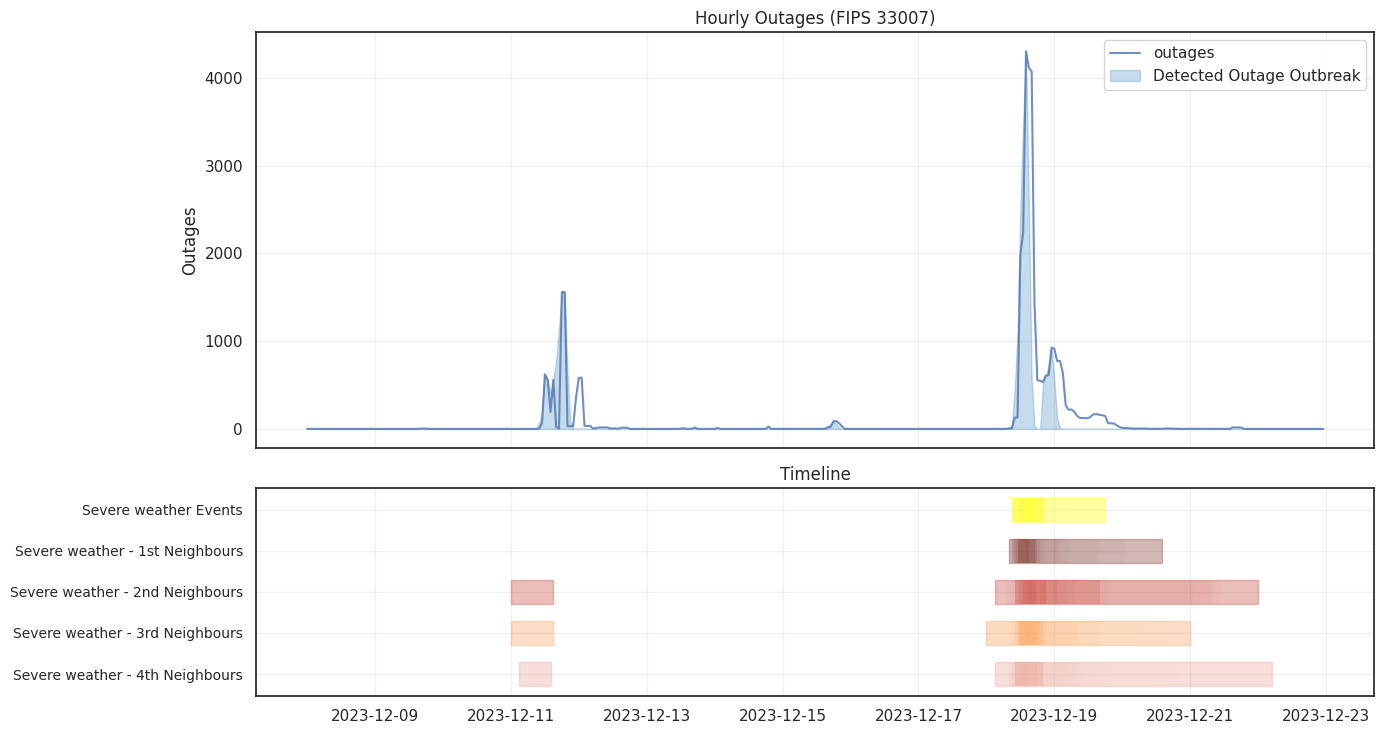

In [51]:
# Show outages for fips n°33007 (Coos County - Oregon)
plot_peaks(df,
       fips=33007,
       cols_to_plot=['outages', 'outages_outbreak'],
       cols_timeline=['Severe_events_count',
                     'Severe_events_count_sum_among_1st_neighbours',
                     'Severe_events_count_sum_among_2nd_neighbours',
                     'Severe_events_count_sum_among_3rd_neighbours',
                     'Severe_events_count_sum_among_4th_neighbours'],
       start_date = '2023-12-08',
       end_date   = '2023-12-22',
      )

___
## <span style="color:#A7C7E7;">**<u>Step 3:</u></span> Correlation Matrix**


#### Below, we can observe significant correlations between outages in neighboring areas.

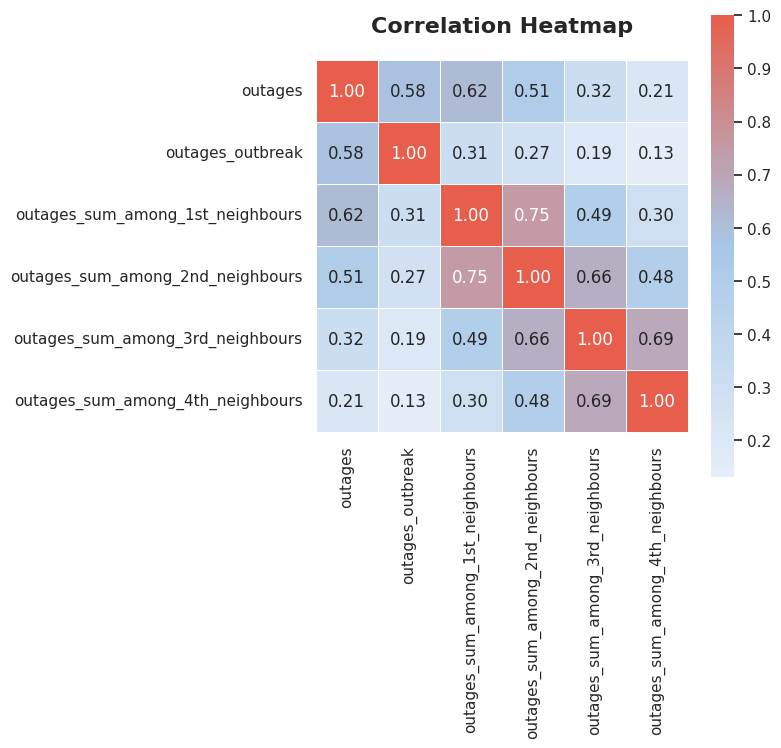

In [52]:
cols = [
         'outages',
         'outages_outbreak',
         'outages_sum_among_1st_neighbours',
         'outages_sum_among_2nd_neighbours',
         'outages_sum_among_3rd_neighbours',
         'outages_sum_among_4th_neighbours',
        ]

# Plot correlation matrix
plot_correlation_matrix(df, cols, figsize=(6, 6)) 

___
## **Delete columns**
> These columns are not useful anymore, so we delete them to save memory.

In [53]:
cols = ['year',
        'envelop',
        'flag_more_than_50_outages',
        
        # Words related to weather events (we keep only aggregated features, like rolling or neighbours features)
        'WORDS_snow',
        'WORDS_wires',
        'WORDS_downed_trees',
        'WORDS_heavy_damage',
        'WORDS_heat_and_fire',
        'WORDS_wind_and_storm',
        'WORDS_water_and_flood',

        # Count storm events of neighbours (we keep only sum over all neighbours)
        'Count_Other_light_sum_among_1st_neighbours',
        'Count_Other_moderate_sum_among_1st_neighbours',
        'Count_Other_severe_sum_among_1st_neighbours',
        'Count_Flood_sum_among_1st_neighbours',
        'Count_Storm_sum_among_1st_neighbours',
        'Count_Wind_sum_among_1st_neighbours',
        'Count_Fire_sum_among_1st_neighbours',
        'Count_Other_light_sum_among_2nd_neighbours',
        'Count_Other_moderate_sum_among_2nd_neighbours',
        'Count_Other_severe_sum_among_2nd_neighbours',
        'Count_Flood_sum_among_2nd_neighbours',
        'Count_Storm_sum_among_2nd_neighbours',
        'Count_Wind_sum_among_2nd_neighbours',
        'Count_Fire_sum_among_2nd_neighbours',
        'Count_Other_light_sum_among_3rd_neighbours',
        'Count_Other_moderate_sum_among_3rd_neighbours',
        'Count_Other_severe_sum_among_3rd_neighbours',
        'Count_Flood_sum_among_3rd_neighbours',
        'Count_Storm_sum_among_3rd_neighbours',
        'Count_Wind_sum_among_3rd_neighbours',
        'Count_Fire_sum_among_3rd_neighbours',
        'Count_Other_light_sum_among_4th_neighbours',
        'Count_Other_moderate_sum_among_4th_neighbours',
        'Count_Other_severe_sum_among_4th_neighbours',
        'Count_Flood_sum_among_4th_neighbours',
        'Count_Storm_sum_among_4th_neighbours',
        'Count_Wind_sum_among_4th_neighbours',
        'Count_Fire_sum_among_4th_neighbours',
        
        # Words of neighbours (we only keep aggregated features over all neighbours)
        'WORDS_wind_and_storm_sum_among_1st_neighbours',
        'WORDS_downed_trees_sum_among_1st_neighbours',
        'WORDS_heavy_damage_sum_among_1st_neighbours',
        'WORDS_wires_sum_among_1st_neighbours',
        'WORDS_water_and_flood_sum_among_1st_neighbours',
        'WORDS_heat_and_fire_sum_among_1st_neighbours',
        'WORDS_snow_sum_among_1st_neighbours',
        'WORDS_wind_and_storm_sum_among_2nd_neighbours',
        'WORDS_downed_trees_sum_among_2nd_neighbours',
        'WORDS_heavy_damage_sum_among_2nd_neighbours',
        'WORDS_wires_sum_among_2nd_neighbours',
        'WORDS_water_and_flood_sum_among_2nd_neighbours',
        'WORDS_heat_and_fire_sum_among_2nd_neighbours',
        'WORDS_snow_sum_among_2nd_neighbours',
        'WORDS_wind_and_storm_sum_among_3rd_neighbours',
        'WORDS_downed_trees_sum_among_3rd_neighbours',
        'WORDS_heavy_damage_sum_among_3rd_neighbours',
        'WORDS_wires_sum_among_3rd_neighbours',
        'WORDS_water_and_flood_sum_among_3rd_neighbours',
        'WORDS_heat_and_fire_sum_among_3rd_neighbours',
        'WORDS_snow_sum_among_3rd_neighbours',
        'WORDS_wind_and_storm_sum_among_4th_neighbours',
        'WORDS_downed_trees_sum_among_4th_neighbours',
        'WORDS_heavy_damage_sum_among_4th_neighbours',
        'WORDS_wires_sum_among_4th_neighbours',
        'WORDS_water_and_flood_sum_among_4th_neighbours',
        'WORDS_heat_and_fire_sum_among_4th_neighbours',
        'WORDS_snow_sum_among_4th_neighbours',

        # Count weather events of neighbours (we only keep aggregated features over all neighbours)
        'MAGNITUDE_sum_among_3rd_neighbours',
        'MAGNITUDE_sum_among_4th_neighbours',
        'MAGNITUDE_sum_among_ALL_neighbours'

       ]

print("UNKNOWN COLS : ", [x for x in cols if x not in df])
cols = [x for x in cols if x in df]

df = df.drop(columns = cols)

        
# Show
print(df.shape)
df.head(1)

UNKNOWN COLS :  ['WORDS_snow_sum_among_1st_neighbours', 'WORDS_snow_sum_among_2nd_neighbours', 'WORDS_snow_sum_among_3rd_neighbours', 'WORDS_snow_sum_among_4th_neighbours']
(4268242, 99)


fips        date  month  week  dayofweek  hour  outages  \
1001  1001  2023-11-01     11  44.0          2     0      4.0   

      outages_outbreak  \
1001               0.0   

      Proportion_of_fips_within_300km_with_more_than_50_outages  \
1001                                           0.011299           

      Proportion_of_fips_within_600km_with_more_than_50_outages  ...  \
1001                                           0.015717          ...   

      WORDS_heavy_damage_sum_among_ALL_neighbours  \
1001                                         18.0   

      WORDS_wires_sum_among_ALL_neighbours  \
1001                                   0.0   

      WORDS_heat_and_fire_sum_among_ALL_neighbours  \
1001                                          25.0   

      Count_Other_light_sum_among_ALL_neighbours  \
1001                                         0.0   

      Count_Other_moderate_sum_among_ALL_neighbours  \
1001                                            0.0   

      Count_Other_severe_sum_among_ALL_neighbours  \
1001                                         16.0   

      Count_Flood_sum_among_ALL_neighbours  \
1001                                   0.0   

      Count_Storm_sum_among_ALL_neighbours  \
1001                                   0.0   

      Count_Wind_sum_among_ALL_neighbours  Count_Fire_sum_among_ALL_neighbours  
1001                                  0.0                                  0.0  

[1 rows x 99 columns]

___
___
# <span style="color:#0096FF;">**Part 12: Add Shifted & Rolling Features.**</span>

### **Goals**
- Capture temporal patterns and trends by adding lagged (shifted) and rolling statistics on key features like outages, weather, and storm events.

### Rolling Sum

In [54]:
cols_to_shift = [
                 'WORDS_wind_and_storm_sum_among_ALL_neighbours',
                 'WORDS_downed_trees_sum_among_ALL_neighbours',
                 'WORDS_wires_sum_among_ALL_neighbours',
                 'Severe_events_count_sum_among_1st_neighbours',
                 'Severe_events_count_sum_among_2nd_neighbours',
                 'Severe_events_count_sum_among_ALL_neighbours',
                ]
# For each column, compute the highest value met in the last x hours
for n_hours in [6, 24] :
    for k in tqdm(cols_to_shift):
        df[f'Sum_of_{k}_over_last_{n_hours}hours'] = df.groupby('fips')[k].rolling(window=n_hours).sum().fillna(0).values

# ------------------------------------------------------------------------

cols_to_shift = [
                 'MAGNITUDE_sum_among_1st_neighbours',
                 'MAGNITUDE_sum_among_2nd_neighbours',
                ]
# For each column, compute the highest value met in the last x hours
for n_hours in [12] :
    for k in tqdm(cols_to_shift):
        df[f'Max_of_{k}_over_last_{n_hours}hours'] = df.groupby('fips')[k].rolling(window=n_hours).max().fillna(0).values

# ------------------------------------------------------------------------
    
# Show
print(df.shape)
df.head(1)

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

(4268242, 113)


fips        date  month  week  dayofweek  hour  outages  \
1001  1001  2023-11-01     11  44.0          2     0      4.0   

      outages_outbreak  \
1001               0.0   

      Proportion_of_fips_within_300km_with_more_than_50_outages  \
1001                                           0.011299           

      Proportion_of_fips_within_600km_with_more_than_50_outages  ...  \
1001                                           0.015717          ...   

      Sum_of_Severe_events_count_sum_among_2nd_neighbours_over_last_6hours  \
1001                                                0.0                      

      Sum_of_Severe_events_count_sum_among_ALL_neighbours_over_last_6hours  \
1001                                                0.0                      

      Sum_of_WORDS_wind_and_storm_sum_among_ALL_neighbours_over_last_24hours  \
1001                                                0.0                        

      Sum_of_WORDS_downed_trees_sum_among_ALL_neighbours_over_last_24hours  \
1001                                                0.0                      

      Sum_of_WORDS_wires_sum_among_ALL_neighbours_over_last_24hours  \
1001                                                0.0               

      Sum_of_Severe_events_count_sum_among_1st_neighbours_over_last_24hours  \
1001                                                0.0                       

      Sum_of_Severe_events_count_sum_among_2nd_neighbours_over_last_24hours  \
1001                                                0.0                       

      Sum_of_Severe_events_count_sum_among_ALL_neighbours_over_last_24hours  \
1001                                                0.0                       

      Max_of_MAGNITUDE_sum_among_1st_neighbours_over_last_12hours  \
1001                                                0.0             

      Max_of_MAGNITUDE_sum_among_2nd_neighbours_over_last_12hours  
1001                                                0.0            

[1 rows x 113 columns]

### Rolling Max

In [55]:
cols_to_shift = [
                 'outages',
                 'outages_sum_among_1st_neighbours',
                 'outages_sum_among_2nd_neighbours',
                 'outages_sum_among_ALL_neighbours',
                ]

# For each column, compute the highest value met in the last x hours
for n_hours in [12, 36] :
    for k in tqdm(cols_to_shift):
        df[f'Max_of_{k}_over_last_{n_hours}hours'] = df.groupby('fips')[k].rolling(window=n_hours).max().fillna(0).values


# ------------------------------------------------------------------------

cols_to_shift = [
                 # Storm events of county
                 'Count_Other_light',
                 'Count_Other_moderate',
                 'Severe_events_count',
                 # Storm events of all neighbours (1st to 4th degree)
                 'Severe_events_count_sum_among_ALL_neighbours',
                 'Count_Other_light_sum_among_ALL_neighbours',
                 'Count_Other_moderate_sum_among_ALL_neighbours',
                 'Count_Other_severe_sum_among_ALL_neighbours',
                 'Count_Flood_sum_among_ALL_neighbours',
                 'Count_Storm_sum_among_ALL_neighbours',
                 'Count_Wind_sum_among_ALL_neighbours',
                ]

# For each column, compute the highest value met in the last x hours
for n_hours in [6] :
    for k in tqdm(cols_to_shift):
        df[f'Max_of_{k}_over_last_{n_hours}hours'] = df.groupby('fips')[k].rolling(window=n_hours).max().fillna(0).values

# ------------------------------------------------------------------------

# Show
print(df.shape)
df.head(1)

100%|██████████| 10/10 [00:06<00:00,  1.45it/s]

(4268242, 131)


fips        date  month  week  dayofweek  hour  outages  \
1001  1001  2023-11-01     11  44.0          2     0      4.0   

      outages_outbreak  \
1001               0.0   

      Proportion_of_fips_within_300km_with_more_than_50_outages  \
1001                                           0.011299           

      Proportion_of_fips_within_600km_with_more_than_50_outages  ...  \
1001                                           0.015717          ...   

      Max_of_Count_Other_light_over_last_6hours  \
1001                                        0.0   

      Max_of_Count_Other_moderate_over_last_6hours  \
1001                                           0.0   

      Max_of_Severe_events_count_over_last_6hours  \
1001                                          0.0   

      Max_of_Severe_events_count_sum_among_ALL_neighbours_over_last_6hours  \
1001                                                0.0                      

      Max_of_Count_Other_light_sum_among_ALL_neighbours_over_last_6hours  \
1001                                                0.0                    

      Max_of_Count_Other_moderate_sum_among_ALL_neighbours_over_last_6hours  \
1001                                                0.0                       

      Max_of_Count_Other_severe_sum_among_ALL_neighbours_over_last_6hours  \
1001                                                0.0                     

      Max_of_Count_Flood_sum_among_ALL_neighbours_over_last_6hours  \
1001                                                0.0              

      Max_of_Count_Storm_sum_among_ALL_neighbours_over_last_6hours  \
1001                                                0.0              

      Max_of_Count_Wind_sum_among_ALL_neighbours_over_last_6hours  
1001                                                0.0            

[1 rows x 131 columns]

### Diff (difference of consecutive rows)

In [56]:
cols_to_shift = ['vector_weights', # Projection of outages waves
                ]
    
for k in tqdm(cols_to_shift):
    df[f"DIFF_{k}"] = df.groupby('fips')[k].diff()

# ------------------------------------------------------------------------


cols_to_shift = ['outages',
                 'outages_outbreak',
                ]
    
for k in tqdm(cols_to_shift):
    df[f'DIFF_{k}'] = df.groupby('fips')[k].diff().fillna(0)
    
    for n_hours in [6, 24]:
        # Difference compared to value x hours ago
        df[f"DIFF_{k}_from_{n_hours}hours_ago"] = df[k] - df.groupby('fips')[k].shift(n_hours)
        # Biggest difference over the last x hours
        df[f"Biggest_raise_of_{k}_over_last_{n_hours}h"] = df.groupby('fips')[f'DIFF_{k}'].rolling(window=n_hours).max().fillna(0).values

# Show
print(df.shape)
df.head(1)

100%|██████████| 2/2 [00:03<00:00,  1.88s/it]

(4268242, 142)


fips        date  month  week  dayofweek  hour  outages  \
1001  1001  2023-11-01     11  44.0          2     0      4.0   

      outages_outbreak  \
1001               0.0   

      Proportion_of_fips_within_300km_with_more_than_50_outages  \
1001                                           0.011299           

      Proportion_of_fips_within_600km_with_more_than_50_outages  ...  \
1001                                           0.015717          ...   

      DIFF_outages  DIFF_outages_from_6hours_ago  \
1001           0.0                           NaN   

      Biggest_raise_of_outages_over_last_6h  DIFF_outages_from_24hours_ago  \
1001                                    0.0                            NaN   

      Biggest_raise_of_outages_over_last_24h  DIFF_outages_outbreak  \
1001                                     0.0                    0.0   

      DIFF_outages_outbreak_from_6hours_ago  \
1001                                    NaN   

      Biggest_raise_of_outages_outbreak_over_last_6h  \
1001                                             0.0   

      DIFF_outages_outbreak_from_24hours_ago  \
1001                                     NaN   

      Biggest_raise_of_outages_outbreak_over_last_24h  
1001                                              0.0  

[1 rows x 142 columns]

### Some features I tested that proved to be ineffective in the model
> Non-exhaustive list

In [57]:
# USELESS FEATURES

"""
cols_to_shift = ['outages',
                 'outages_outbreak',
                ]

# Shift
for k in tqdm(cols_to_shift):
    for h in range(1, 5):
        df[f"{k}_{h}hours_ago"] = df.groupby('fips')[k].shift(h)

# Rolling values over the last x hours
for n_hours in [6, 12, 24] :
    for k in tqdm(cols_to_shift):
        df[f'Mean_of_{k}_over_last_{n_hours}hours'] = df.groupby('fips')[k].rolling(window=n_hours).mean().fillna(0).values
        df[f'Max_of_{k}_over_last_{n_hours}hours']  = df.groupby('fips')[k].rolling(window=n_hours).max().fillna(0).values
        df[f'Sum_of_{k}_over_last_{n_hours}hours']  = df.groupby('fips')[k].rolling(window=n_hours).sum().fillna(0).values
        df[f'Std_of_{k}_over_last_{n_hours}hours']  = df.groupby('fips')[k].rolling(window=n_hours).std().fillna(0).values

# Show
print(df.shape)
df.head(1)
"""
print()

#### Number of hours since some values has reached some thresholds.

In [58]:
# USELESS FEATS

"""
for col in ['Severe_events_count_sum_among_1st_neighbours',
            'Severe_events_count_sum_among_2nd_neighbours',
            'Severe_events_count_sum_among_3rd_neighbours',
            'Severe_events_count_sum_among_4th_neighbours',
            'Severe_events_count_sum_among_ALL_neighbours',
           ]:

    df = get_days_since_last_positive_value(df,
                                            col = col,
                                            col_to_create = f'nhours_since_last_positive_{col}',
                                           )

# Show
print(df.shape)
df.head(1)

"""
print()

___
## Future information about weather
- Storms and wind forecasts are generally available and reliable at least 1 day ahead.

> These features have NOT been included. In fact, I was afraid it might cause data leakage because the information would have been more exact than actual weather forecasts are in real life.
> I could not find publicly available external data containing an history of weather forecasts since several years.

In [59]:
# USELESS FEATS

"""
for k in [
          'Count_Storm',
          'Count_Wind',
          'Count_Storm_sum_among_ALL_neighbours',
          'Count_Wind_sum_among_ALL_neighbours',
          'MAGNITUDE_sum_among_ALL_neighbours',
          'Severe_events_count',
          'Severe_events_count_sum_among_ALL_neighbours',
         ]:

    # Compute number of hours before next positive count of weather event
    df = get_days_before_next_positive_value(df,
                                             col = k,
                                             col_to_create = f'nhours_before_next_positive_{k}',
                                            )

    # Forecasts are generally not available (or reliable) further than 24h ahead, so we clip values between 0 and 24 hours
    df[f'nhours_before_next_positive_{k}'] = df[f'nhours_before_next_positive_{k}'].clip(0, 24)


# Show
print(df.shape)
df.head(1)
"""
print()

___
___
# <span style="color:#0096FF;">**Part 13: Create target for model training and performance evaluation.**</span>

### **Goals**
- Define a clear target variable for model training: predicting outages within the next 6 hours.
- Modify the target variable slightly to indicate whether an outage outbreak is imminent based on specific outage values (add 0.01). This modification will enable the use of a custom metric during training for better performance evaluations.

### Create target : outages 6 hours in future.

In [60]:
# Outages 6 hours in future
df['outages_in_6hours'] = df.groupby('fips')['outages'].shift(-6)
df['outages_outbreak_in_6hours'] = df.groupby('fips')['outages_outbreak'].shift(-6)

### Slightly modify target to use a custom metric during the training and evaluation phases.
> - Idea : identify when a peak is about to happen. During this periods, we will under-penalize outages over-estimations, because these are "good" false positives.

In [61]:
# We will try to make predictions 6 hours ahead
k = 'outages_outbreak'

# Force int type
df[k] = round(df[k].fillna(0)).astype(int)

# Shift
df[f'{k}_in_6hours'] = df.groupby('fips')[k].shift(-6)

# Now, an interesting part ! If we know a peak is about to happen, we add a very small value to the target column.
# It will allow to use a customed metric during the training phase, that under-penalize errors when we predict big outages a few hours too early.
# In fact, predicting some outage outbreaks 1h too soon is better than 1h too late !
mask = (df[f'{k}_in_6hours'] - df['Max_of_outages_over_last_12hours'] >= 100) # At least 100 more outages than the mean over the past 12 hours
df.loc[mask, k] += 1e-2 # Add a very small amount of outages to identify periods just behind peaks
    
# Overwrite
df[f'{k}_in_6hours'] = df.groupby('fips')[k].shift(-6)

# Round again to avoid any leaks (only the target must be slightly modified, not the features)
df[k] = round(df[k]).astype(int)

# Diffuse the 0.01 additif if we are on a ascending slope
for _ in range(2):
    mask = (df.groupby('fips')[f'{k}_in_6hours'].diff() > -10) & (df.groupby('fips')[f'{k}_in_6hours'].shift(1).astype(str).str.endswith('.01'))
    df.loc[mask, f'{k}_in_6hours'] = round(df.loc[mask, f'{k}_in_6hours']) + 1e-2

# Show
print(df.shape)
df.head(1)

(4268242, 144)


fips        date  month  week  dayofweek  hour  outages  \
1001  1001  2023-11-01     11  44.0          2     0      4.0   

      outages_outbreak  \
1001                 0   

      Proportion_of_fips_within_300km_with_more_than_50_outages  \
1001                                           0.011299           

      Proportion_of_fips_within_600km_with_more_than_50_outages  ...  \
1001                                           0.015717          ...   

      Biggest_raise_of_outages_over_last_6h  DIFF_outages_from_24hours_ago  \
1001                                    0.0                            NaN   

      Biggest_raise_of_outages_over_last_24h  DIFF_outages_outbreak  \
1001                                     0.0                    0.0   

      DIFF_outages_outbreak_from_6hours_ago  \
1001                                    NaN   

      Biggest_raise_of_outages_outbreak_over_last_6h  \
1001                                             0.0   

      DIFF_outages_outbreak_from_24hours_ago  \
1001                                     NaN   

      Biggest_raise_of_outages_outbreak_over_last_24h  outages_in_6hours  \
1001                                              0.0                0.0   

      outages_outbreak_in_6hours  
1001                         0.0  

[1 rows x 144 columns]

#### Undersample df (for training)

In [62]:
"""
# Low outages : keep only 2% of rows / High outages : keep 50%
mask_low_outages = (df['outages_outbreak'] == 0) | (df['outages_outbreak_in_6hours'] == 0)
if len(df)>0:
    print(f"Low outages : {len(df[mask_low_outages])}/{len(df)} ({round(100*len(df[mask_low_outages])/len(df), 1)}%)")

# Concat
df = pd.concat([df[~mask_low_outages].sample(frac=1, random_state=1),
                df[mask_low_outages].sample(frac=0.1, random_state=1),
               ]).reset_index(drop=True)

# Show
print(df.shape)
df.head()
"""
print()

#### Optimize dtypes to reduce memory usage

In [63]:
# Reduce memory usage of df by optimizing its dtypes
df = reduce_memory_usage(df)

# Show
print(df.shape)
df.head(1)

BEFORE: Memory usage of dataframe is 3317.30 MB
AFTER: Memory usage became:  1526.3  MB
(4268242, 144)


fips        date  month  week  dayofweek  hour  outages  \
1001  1001  2023-11-01     11  44.0          2     0      4.0   

      outages_outbreak  \
1001                 0   

      Proportion_of_fips_within_300km_with_more_than_50_outages  \
1001                                           0.011299           

      Proportion_of_fips_within_600km_with_more_than_50_outages  ...  \
1001                                           0.015717          ...   

      Biggest_raise_of_outages_over_last_6h  DIFF_outages_from_24hours_ago  \
1001                                    0.0                            NaN   

      Biggest_raise_of_outages_over_last_24h  DIFF_outages_outbreak  \
1001                                     0.0                    0.0   

      DIFF_outages_outbreak_from_6hours_ago  \
1001                                    NaN   

      Biggest_raise_of_outages_outbreak_over_last_6h  \
1001                                             0.0   

      DIFF_outages_outbreak_from_24hours_ago  \
1001                                     NaN   

      Biggest_raise_of_outages_outbreak_over_last_24h  outages_in_6hours  \
1001                                              0.0                0.0   

      outages_outbreak_in_6hours  
1001                         0.0  

[1 rows x 144 columns]

___
___
# <span style="color:#0096FF;">**Part 14: Export df as a CSV.**</span>

### **Goal**
- Export the dataframe as a CSV file to make it available for future use (training or inference).

In [64]:
%%time

# Export df to CSV
df.to_csv(output_dirpath  + 'df_hourly_outages.csv', index=False)

# Export optimized dtypes
joblib.dump(df.dtypes.to_dict(), output_dirpath  + "df_optimized_dtypes.joblib")

CPU times: user 7min 28s, sys: 8.74 s, total: 7min 37s
Wall time: 7min 38s


['/kaggle/working/df_optimized_dtypes.joblib']